In [1]:
"""
===-*- Statistical Analysis Tool -*-===
=====-*- General -*-=====
Copyright (c) makkiblog.com
BSD-2 License 
coding: utf-8

vvvCODEvvv
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import multivariate_normal
from matplotlib import cm
import plotly.graph_objects as go

# Set up better plotting defaults
plt.rcParams['figure.figsize'] = [10, 6]

# Statistical Process Control Function Definitions

In [2]:
class ProcessControl:
    def __init__(self):
        """Initialize the process control environment."""
        self.data = None
        self.spec_limits = {}
        self.distribution_fits = {}
        self.active_column = None
        
    def load_data(self, data, column=None):
        """Load process data into the environment.
        
        Parameters:
        -----------
        data : pandas.DataFrame or numpy.array
            Process data to analyze
        column : str, optional
            If data is DataFrame, specify column to analyze
        """
        if isinstance(data, pd.DataFrame):
            self.data = data
            if column is not None:
                if column in self.data.columns:
                    self.active_column = column
                else:
                    raise ValueError(f"Column '{column}' not found in DataFrame")
            elif len(data.columns) > 0:
                # Set the first column as active by default
                self.active_column = data.columns[0]
                print(f"No column specified. Using '{self.active_column}' as the active column.")
            else:
                raise ValueError("DataFrame has no columns")
        else:
            # Handle numpy array or other array-like data
            self.data = pd.DataFrame({'data': np.array(data)})
            self.active_column = 'data'
    
    def set_active_column(self, column):
        """Set the active column for analysis.
        
        Parameters:
        -----------
        column : str
            Column name to use for analysis
        """
        if self.data is None:
            raise ValueError("No data loaded. Use load_data() first.")
            
        if column in self.data.columns:
            self.active_column = column
        else:
            raise ValueError(f"Column '{column}' not found in data")
    
    def get_column_data(self):
        """Get the active column data for analysis."""
        if self.data is None:
            raise ValueError("No data loaded. Use load_data() first.")
            
        if self.active_column is None:
            raise ValueError("No active column set. Use set_active_column() first.")
            
        return self.data[self.active_column].values
            
    def set_specification_limits(self, usl, lsl, target=None):
        """Set specification limits for capability analysis.
        
        Parameters:
        -----------
        usl : float
            Upper specification limit
        lsl : float
            Lower specification limit
        target : float, optional
            Target value for process
        """
        self.spec_limits = {
            'USL': usl,
            'LSL': lsl,
            'Target': target
        }


    def calculate_capability(self):
        """Calculate additional process capability indices (Pp, Ppk, Cpm, Cpkm).
        
        Returns:
        --------
        dict
            Dictionary containing capability indices
        """
        if not self.spec_limits:
            raise ValueError("Specification limits not set")
            
        data = self.get_column_data()
        n = len(data)
        mean = np.mean(data)
        std = np.std(data)

        # Calculate Cp
        cp = (self.spec_limits['USL'] - self.spec_limits['LSL']) / (6 * std)
        
        # Calculate Cpk
        cpu = (self.spec_limits['USL'] - mean) / (3 * std)
        cpl = (mean - self.spec_limits['LSL']) / (3 * std)
        cpk = min(cpu, cpl)
        
        # Calculate Pp and Ppk
        pp = (self.spec_limits['USL'] - self.spec_limits['LSL']) / (6 * std)
        ppk = min((self.spec_limits['USL'] - mean) / (3 * std), (mean - self.spec_limits['LSL']) / (3 * std))
        
        # Calculate Cpm and Cpkm
        if self.spec_limits['Target']:
            cpm = (self.spec_limits['USL'] - self.spec_limits['LSL']) / (6 * np.sqrt(std**2 + (mean - self.spec_limits['Target'])**2))
            cpkm = min((self.spec_limits['USL'] - mean) / (3 * np.sqrt(std**2 + (mean - self.spec_limits['Target'])**2)),
                       (mean - self.spec_limits['LSL']) / (3 * np.sqrt(std**2 + (mean - self.spec_limits['Target'])**2)))
        else:
            cpm = None
            cpkm = None
        
        return {
            'Cp': cp,
            'Cpk': cpk,
            'Cpu': cpu,
            'Cpl': cpl,
            'Pp': pp,
            'Ppk': ppk,
            'Cpm': cpm,
            'Cpkm': cpkm,
            'n': n
        }
        

    def fit_distribution(self, distribution='normal'):
        """Fit data to specified distribution.
        
        Parameters:
        -----------
        distribution : str
            Distribution type ('normal', 'weibull', or 'lognormal')
            
        Returns:
        --------
        dict
            Dictionary containing distribution parameters and fit statistics
        """
        data = self.get_column_data()
        
        if distribution.lower() == 'normal':
            params = stats.norm.fit(data)
            dist = stats.norm(*params)
        elif distribution.lower() == 'weibull':
            params = stats.weibull_min.fit(data, floc=0)
            dist = stats.weibull_min(*params)
        elif distribution.lower() == 'lognormal':
            # For lognormal, we need to handle the parameterization
            # s is the shape parameter (standard deviation of the log of the data)
            # scale is exp(mean of the log of the data)
            params = stats.lognorm.fit(data, floc=0)
            dist = stats.lognorm(*params)
            
            # Add some useful derived parameters for interpretation
            shape_s = params[0]  # s parameter (sigma)
            scale = params[2]    # scale parameter (exp(mu))
            
            # Calculate mu and sigma of the underlying normal distribution
            mu = np.log(scale)
            sigma = shape_s
            
            # Add these to the params for easier interpretation
            params = (*params, mu, sigma)
        else:
            raise ValueError("Unsupported distribution. Choose 'normal', 'weibull', or 'lognormal'")
            
        # Calculate fit statistics
        ks_stat, ks_p = stats.kstest(data, dist.cdf)
        
        return {
            'distribution': distribution,
            'parameters': params,
            'ks_stat': ks_stat,
            'ks_p': ks_p,
            'distribution_obj': dist
        }

    def plot_distribution(self, distribution_fit=None):
        """Create histogram with fitted distribution overlay.
        
        Parameters:
        -----------
        distribution_fit : dict, optional
            Distribution fit results from fit_distribution()
        """
        data = self.get_column_data()
        plt.figure()
        
        # Plot histogram
        sns.histplot(data, stat='density', alpha=0.6, label='Data', color='#4472C4')
        
        # Plot fitted distribution if provided
        if distribution_fit:
            x = np.linspace(min(data), max(data), 1000)
            y = distribution_fit['distribution_obj'].pdf(x)
            plt.plot(x, y, 'r-', label=f"Fitted {distribution_fit['distribution']}")
            
            # Add distribution parameters to the plot
            if distribution_fit['distribution'].lower() == 'normal':
                mu, sigma = distribution_fit['parameters']
                param_text = f"μ = {mu:.4f}, σ = {sigma:.4f}"
            elif distribution_fit['distribution'].lower() == 'weibull':
                c, loc, scale = distribution_fit['parameters']
                param_text = f"c = {c:.4f}, scale = {scale:.4f}"
            elif distribution_fit['distribution'].lower() == 'lognormal':
                s, loc, scale, mu, sigma = distribution_fit['parameters']
                param_text = f"μ_log = {mu:.4f}, σ_log = {sigma:.4f}"
            else:
                param_text = f"params = {distribution_fit['parameters']}"
                
            plt.annotate(param_text, xy=(0.05, 0.95), xycoords='axes fraction',
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        
        plt.title(f'Process Distribution Analysis: {self.active_column}')
        if distribution_fit:
            plt.title(f'Process Distribution Analysis: {self.active_column} - {distribution_fit["distribution"]}')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.show()
            
    def plot_capability(self):
        """Create capability plot showing process distribution and limits."""
        data = self.get_column_data()
        
        plt.figure()
        
        # Plot histogram
        sns.histplot(data, stat='density', alpha=0.6, label='Data', color='#4472C4')
        
        # Plot normal distribution fit
        mean = np.mean(data)
        std = np.std(data)
        x = np.linspace(min(data), max(data), 100)
        y = stats.norm.pdf(x, mean, std)
        plt.plot(x, y, 'r-', label='Normal Fit')
        
        # Add specification limits
        if self.spec_limits:
            plt.axvline(x=self.spec_limits['USL'], color='red', linestyle='--', label='USL')
            plt.axvline(x=self.spec_limits['LSL'], color='red', linestyle='--', label='LSL')
            if self.spec_limits['Target']:
                plt.axvline(x=self.spec_limits['Target'], color='green', linestyle='-', label='Target')
        
        plt.title(f'Process Capability Analysis: {self.active_column}')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
        plt.tight_layout()
        plt.show()
        
    def calculate_correlation(self, x_column, y_column):
        """Calculate correlation between two columns.
        
        Parameters:
        -----------
        x_column : str
            Name of the first column
        y_column : str
            Name of the second column
            
        Returns:
        --------
        tuple
            (correlation coefficient, p-value)
        """
        if self.data is None:
            raise ValueError("No data loaded. Use load_data() first.")
            
        if x_column not in self.data.columns:
            raise ValueError(f"Column '{x_column}' not found in data")
            
        if y_column not in self.data.columns:
            raise ValueError(f"Column '{y_column}' not found in data")
            
        # Calculate Pearson correlation coefficient and p-value
        corr, p_value = stats.pearsonr(self.data[x_column], self.data[y_column])
        
        return corr, p_value
    
    def plot_correlation(self, x_column, y_column, add_line=True):
        """Create a scatter plot to visualize correlation between two columns.
        
        Parameters:
        -----------
        x_column : str
            Name of the column for x-axis
        y_column : str
            Name of the column for y-axis
        add_line : bool, optional
            Whether to add a best fit line (default: True)
        """
        if self.data is None:
            raise ValueError("No data loaded. Use load_data() first.")
            
        if x_column not in self.data.columns:
            raise ValueError(f"Column '{x_column}' not found in data")
            
        if y_column not in self.data.columns:
            raise ValueError(f"Column '{y_column}' not found in data")
        
        # Calculate correlation for the title
        corr, p_value = self.calculate_correlation(x_column, y_column)
        
        if add_line:
            # Create scatter plot with regression line
            plt.figure(figsize=(10, 6))
            ax = sns.regplot(x=x_column, y=y_column, data=self.data, scatter_kws={'alpha':0.6})
            plt.title(f'Correlation between {x_column} and {y_column}\nr = {corr:.4f}, p = {p_value:.4e}')
        else:
            # Create simple scatter plot
            plt.figure(figsize=(10, 6))
            ax = sns.scatterplot(x=x_column, y=y_column, data=self.data, alpha=0.6)
            plt.title(f'Scatter plot: {x_column} vs {y_column}\nr = {corr:.4f}, p = {p_value:.4e}')
            
        plt.xlabel(x_column)
        plt.ylabel(y_column)
        plt.tight_layout()
        plt.show()
        
    def correlation_matrix(self, columns=None):
        """Calculate and return the correlation matrix for selected columns.
        
        Parameters:
        -----------
        columns : list, optional
            List of column names to include in the correlation matrix.
            If None, all numeric columns are used.
            
        Returns:
        --------
        pandas.DataFrame
            Correlation matrix
        """
        if self.data is None:
            raise ValueError("No data loaded. Use load_data() first.")
            
        if columns is not None:
            # Check if all specified columns exist
            missing_cols = [col for col in columns if col not in self.data.columns]
            if missing_cols:
                raise ValueError(f"Columns not found in data: {missing_cols}")
            
            # Select only the specified columns
            data_subset = self.data[columns]
        else:
            # Use all numeric columns
            data_subset = self.data.select_dtypes(include=['number'])
            
        # Calculate correlation matrix
        corr_matrix = data_subset.corr()
        
        return corr_matrix
    
    def plot_correlation_matrix(self, columns=None):
        """Plot a heatmap of the correlation matrix.
        
        Parameters:
        -----------
        columns : list, optional
            List of column names to include in the correlation matrix.
            If None, all numeric columns are used.
        """
        corr_matrix = self.correlation_matrix(columns)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
        plt.title('Correlation Matrix')
        plt.tight_layout()
        plt.show()


    def plot_normal_probability(self, column):
        """Create a normal probability plot for a given column with sigma reference points.
        
        Parameters:
        -----------
        column : str
            Name of the column to plot
        """
        if self.data is None:
            raise ValueError("No data loaded. Use load_data() first.")
            
        if column not in self.data.columns:
            raise ValueError(f"Column '{column}' not found in data")
        
        # Create figure and axis
        fig, ax = plt.subplots(figsize=(10, 7))
        
        # Generate the probability plot
        result = stats.probplot(self.data[column], plot=ax)
        
        # Extract the results
        (osm, osr), (slope, intercept, r) = result
        
        # Find the closest points to sigma = -1, 0, and 1
        sigma_values = [-1, 0, 1]
        sigma_indices = []
        
        for sigma in sigma_values:
            # Find the index of the closest theoretical quantile to our sigma value
            closest_idx = np.abs(osm - sigma).argmin()
            sigma_indices.append(closest_idx)
        
        # Add annotations for these points
        for i, sigma in zip(sigma_indices, sigma_values):
            x_val = osm[i]
            y_val = osr[i]
            ax.plot(x_val, y_val, 'ro', markersize=8)  # Red circle marker
            ax.annotate(f'σ={sigma}: {y_val:.2f}', 
                       xy=(x_val, y_val),
                       xytext=(x_val + 0.2, y_val),
                       arrowprops=dict(arrowstyle="->", color='red'),
                       bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.8))
        
        # Print the values to console as well
        print(f"Ordered values at reference points:")
        for i, sigma in zip(sigma_indices, sigma_values):
            print(f"σ = {sigma}: {osr[i]:.4f} (theoretical quantile = {osm[i]:.4f})")
        
        # Add title with correlation coefficient
        ax.set_title(f'Normal Probability Plot for {column}\nr = {r:.4f}')
        ax.set_xlabel('Theoretical Quantiles (σ)')
        ax.set_ylabel('Ordered Values')
        
        # Add a legend explaining the plot
        textstr = '\n'.join([
            'Reference Points:',
            f'σ = -1: {osr[sigma_indices[0]]:.2f}',
            f'σ = 0: {osr[sigma_indices[1]]:.2f}',
            f'σ = 1: {osr[sigma_indices[2]]:.2f}'
        ])
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props)
        
        plt.tight_layout()
        plt.show()
    
    def plot_weibull_probability(self, column, shape=None):
        """Create a Weibull probability plot for a given column with reference points.
        
        Parameters:
        -----------
        column : str
            Name of the column to plot
        shape : float, optional
            Shape parameter (k) for the Weibull distribution (default=1.5)
            If None, the shape will be estimated from the data
        """
        if self.data is None:
            raise ValueError("No data loaded. Use load_data() first.")
            
        if column not in self.data.columns:
            raise ValueError(f"Column '{column}' not found in data")
        
        # Get the data and remove NaN values
        data = self.data[column].dropna().values
        
        if len(data) == 0:
            raise ValueError(f"No valid data in column '{column}'")
        
        # Weibull distribution requires positive values
        if np.any(data <= 0):
            raise ValueError("Weibull distribution requires all positive values")
        
        # Sort the data
        sorted_data = np.sort(data)
        n = len(sorted_data)
        
        # Calculate plotting positions using median rank formula
        plotting_positions = (np.arange(1, n + 1)) / (n + 1)
        
        # If shape parameter is not provided, estimate it from the data
        if shape is None:
            # Fit Weibull distribution to estimate shape parameter
            shape, loc, scale = stats.weibull_min.fit(data, floc=0)
            print(f"Estimated Weibull shape parameter: {shape:.4f}")
        
        # Generate theoretical quantiles from Weibull distribution
        theoretical_quantiles = stats.weibull_min.ppf(plotting_positions, shape)
        
        # Create figure and axis with more space
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Plot the data points
        ax.plot(theoretical_quantiles, sorted_data, 'bo', markersize=4, alpha=0.6)
        
        # Fit a line to the data
        slope, intercept = np.polyfit(theoretical_quantiles, sorted_data, 1)
        fitted_line = slope * theoretical_quantiles + intercept
        ax.plot(theoretical_quantiles, fitted_line, 'b-', linewidth=2, label='Best fit line')
        
        # Calculate correlation coefficient
        r = np.corrcoef(theoretical_quantiles, sorted_data)[0, 1]
        
        # Define reference quantiles for Weibull
        reference_percentiles = [0.1, 0.5, 0.9]
        reference_labels = ['10th %ile', 'Median', '90th %ile']
        
        
        
        # Calculate data range for smart annotation positioning
        data_range = sorted_data.max() - sorted_data.min()
        
        for i, (percentile, label) in enumerate(zip(reference_percentiles, reference_labels)):
            # Find the theoretical quantile for this percentile
            theoretical_q = stats.weibull_min.ppf(percentile, shape)
            
            # Find the closest point in our theoretical quantiles
            closest_idx = np.abs(theoretical_quantiles - theoretical_q).argmin()
            x_val = theoretical_quantiles[closest_idx]
            y_val = sorted_data[closest_idx]
            
            # Plot the reference point
            ax.plot(x_val, y_val, 'ro', markersize=8, zorder=5)
            
            # Position annotations to avoid overlap
            if i == 0:  # Bottom point
                xytext = (x_val + 0.15, y_val - data_range * 0.05)
            elif i == 1:  # Middle point
                xytext = (x_val + 0.15, y_val)
            else:  # Top point
                xytext = (x_val + 0.15, y_val + data_range * 0.05)
            
            """
            ax.annotate(f'{label}: {y_val:.2f}', 
                    xy=(x_val, y_val),
                    xytext=xytext,
                    arrowprops=dict(arrowstyle="->", color='red', lw=1),
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.8),
                    fontsize=9)
            """
            print(f"{label}: {y_val:.4f} (theoretical quantile = {x_val:.4f})")
        
        
        # Add title with correlation coefficient and shape parameter
        ax.set_title(f'Weibull Probability Plot for {column}\nShape (k) = {shape:.3f}, r = {r:.4f}', 
                    fontsize=12, pad=15)
        ax.set_xlabel('Theoretical Quantiles (Weibull)', fontsize=11)
        ax.set_ylabel('Ordered Values', fontsize=11)
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
        
        # Add info box with reference points
        ref_10 = sorted_data[np.abs(theoretical_quantiles - stats.weibull_min.ppf(0.1, shape)).argmin()]
        ref_50 = sorted_data[np.abs(theoretical_quantiles - stats.weibull_min.ppf(0.5, shape)).argmin()]
        ref_90 = sorted_data[np.abs(theoretical_quantiles - stats.weibull_min.ppf(0.9, shape)).argmin()]
        
        textstr = '\n'.join([
            'Reference Points:',
            f'10th %ile: {ref_10:.2f}',
            f'50th %ile: {ref_50:.2f}',
            f'90th %ile: {ref_90:.2f}'
        ])
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props)
        
        # Use tight_layout with padding to avoid the warning
        #plt.tight_layout(pad=2.0)
        
        plt.subplots_adjust(left=0.1, right=0.85, top=0.93, bottom=0.08)
        plt.show()
    
        return {'shape': shape, 'scale': slope, 'correlation': r}
    
    def plot_uniform_probability(self, column):
        """Create a uniform probability plot for a given column with percentile reference points.
        
        Parameters:
        -----------
        column : str
            Name of the column to plot
        """
        if self.data is None:
            raise ValueError("No data loaded. Use load_data() first.")
            
        if column not in self.data.columns:
            raise ValueError(f"Column '{column}' not found in data")
        
        # Get the data and remove NaN values
        data = self.data[column].dropna().values
        
        if len(data) == 0:
            raise ValueError(f"No valid data in column '{column}'")
        
        # Sort the data
        sorted_data = np.sort(data)
        n = len(sorted_data)
        
        # Calculate plotting positions using median rank formula
        plotting_positions = (np.arange(1, n + 1) - 0.5) / n
        
        # Generate theoretical quantiles from uniform distribution [0, 1]
        theoretical_quantiles = plotting_positions
        
        # Create figure and axis
        fig, ax = plt.subplots(figsize=(10, 7))
        
        # Plot the data points
        ax.plot(theoretical_quantiles, sorted_data, 'bo', markersize=4, alpha=0.6)
        
        # Fit a line to the data
        slope, intercept = np.polyfit(theoretical_quantiles, sorted_data, 1)
        fitted_line = slope * theoretical_quantiles + intercept
        ax.plot(theoretical_quantiles, fitted_line, 'b-', linewidth=2, label='Best fit line')
        
        # Calculate correlation coefficient
        r = np.corrcoef(theoretical_quantiles, sorted_data)[0, 1]
        
        # Find the closest points to percentiles 25%, 50%, and 75%
        percentile_values = [0.25, 0.50, 0.75]
        percentile_indices = []
        
        for percentile in percentile_values:
            # Find the index of the closest theoretical quantile to our percentile value
            closest_idx = np.abs(theoretical_quantiles - percentile).argmin()
            percentile_indices.append(closest_idx)
        
        # Add annotations for these points
        for i, percentile in zip(percentile_indices, percentile_values):
            x_val = theoretical_quantiles[i]
            y_val = sorted_data[i]
            ax.plot(x_val, y_val, 'ro', markersize=8)  # Red circle marker
            ax.annotate(f'{percentile*100:.0f}%: {y_val:.2f}', 
                    xy=(x_val, y_val),
                    xytext=(x_val + 0.05, y_val),
                    arrowprops=dict(arrowstyle="->", color='red'),
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.8))
        
        # Print the values to console as well
        print(f"Ordered values at reference percentiles:")
        for i, percentile in zip(percentile_indices, percentile_values):
            print(f"{percentile*100:.0f}th percentile: {sorted_data[i]:.4f} (theoretical quantile = {theoretical_quantiles[i]:.4f})")
        
        # Estimate uniform distribution parameters from the fitted line
        # For uniform distribution U(a,b): a = intercept, b = intercept + slope
        uniform_a = intercept
        uniform_b = intercept + slope
        
        # Add title with correlation coefficient and uniform parameters
        ax.set_title(f'Uniform Probability Plot for {column}\nr = {r:.4f}, Estimated U({uniform_a:.2f}, {uniform_b:.2f})')
        ax.set_xlabel('Theoretical Quantiles (Uniform [0,1])')
        ax.set_ylabel('Ordered Values')
        
        # Add a legend explaining the plot
        textstr = '\n'.join([
            'Reference Points:',
            f'25th %ile: {sorted_data[percentile_indices[0]]:.2f}',
            f'50th %ile: {sorted_data[percentile_indices[1]]:.2f}',
            f'75th %ile: {sorted_data[percentile_indices[2]]:.2f}',
            '',
            f'Estimated Uniform Parameters:',
            f'Lower bound (a): {uniform_a:.3f}',
            f'Upper bound (b): {uniform_b:.3f}'
        ])
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props)
        
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best')
        plt.tight_layout()
        plt.show()
        
        return {'correlation': r, 'uniform_a': uniform_a, 'uniform_b': uniform_b}
    
    def tolerance_interval(self, alpha=0.05, p=0.95, distribution='normal'):
        """Calculate tolerance interval for the specified distribution.
        
        Parameters:
        -----------
        alpha : float, optional
            Significance level (default: 0.05)
        p : float, optional
            Proportion of the population to be covered (default: 0.95)
        distribution : str, optional
            Distribution type ('normal' or 'weibull') (default: 'normal')
            
        Returns:
        --------
        tuple
            Lower and upper bounds of the tolerance interval
        """
        data = self.get_column_data()
        n = len(data)
        
        if distribution.lower() == 'normal':
            mean = np.mean(data)
            std = np.std(data)
            k = stats.norm.ppf(1 - alpha / 2) * np.sqrt((n - 1) / stats.chi2.ppf(p, n - 1))
            lower = mean - k * std
            upper = mean + k * std
        elif distribution.lower() == 'weibull':
            params = stats.weibull_min.fit(data, floc=0)
            lower = stats.weibull_min.ppf(alpha / 2, *params)
            upper = stats.weibull_min.ppf(1 - alpha / 2, *params)
        else:
            raise ValueError("Unsupported distribution")
            
        return lower, upper

## MultiVariate Analysis Definition

In [3]:
class MultivariateAnalysis:
    def __init__(self, data):
        """Initialize the multivariate analysis with the given data.
        
        Parameters:
        -----------
        data : pandas.DataFrame
            Input data for multivariate analysis
        """
        self.data = data
        
    def principal_component_analysis(self, n_components=None):
        """Perform Principal Component Analysis (PCA) on the data.
        
        Parameters:
        -----------
        n_components : int, optional
            Number of principal components to retain (default: None)
            
        Returns:
        --------
        tuple
            Principal components and explained variance ratio
        """
        pca = PCA(n_components=n_components)
        principal_components = pca.fit_transform(self.data)
        explained_variance_ratio = pca.explained_variance_ratio_
        
        return principal_components, explained_variance_ratio
    
    def partial_least_squares(self, X, y, n_components=None):
        """Perform Partial Least Squares (PLS) regression on the data.
        
        Parameters:
        -----------
        X : pandas.DataFrame
            Input features
        y : pandas.Series
            Target variable
        n_components : int, optional
            Number of PLS components to retain (default: None)
            
        Returns:
        --------
        sklearn.cross_decomposition.PLSRegression
            Fitted PLS regression model
        """
        pls = PLSRegression(n_components=n_components)
        pls.fit(X, y)
        
        return pls
    
    def plot_bivariate_distribution(self, col1, col2, distribution='normal', 
                                    usl1=None, usl2=None, n_points=100, 
                                    figsize=(12, 5), cmap='viridis'):
        """
        Create a bivariate distribution plot using two columns from the stored DataFrame.
        
        Parameters:
        -----------
        col1 : str
            Name of the first column (x-axis)
        col2 : str
            Name of the second column (y-axis)
        distribution : str, optional
            Type of distribution to fit: 'normal' or 'weibull' (default: 'normal')
        usl1 : float, optional
            Upper Specification Limit for col1 (default: None)
        usl2 : float, optional
            Upper Specification Limit for col2 (default: None)
        n_points : int, optional
            Number of points for the grid (default: 100)
        figsize : tuple, optional
            Figure size (width, height) in inches (default: (12, 5))
        cmap : str, optional
            Colormap for the contour plot (default: 'viridis')
            
        Returns:
        --------
        fig_mpl : matplotlib.figure.Figure
            The matplotlib figure object with contour plot
        fig_plotly : plotly.graph_objects.Figure
            The interactive Plotly 3D figure object
        """
        from scipy.stats import multivariate_normal, weibull_min, norm
        from scipy.special import gamma
        import numpy as np
        import matplotlib.pyplot as plt
        import plotly.graph_objects as go
        
        # Validate distribution parameter
        distribution = distribution.lower()
        if distribution not in ['normal', 'weibull']:
            raise ValueError("Please select 'normal' or 'weibull' for distribution parameter")
        
        # Extract the two columns and drop NaN values
        df_subset = self.data[[col1, col2]].dropna()
        
        if len(df_subset) < 2:
            raise ValueError("Need at least 2 valid data points")
        
        # Create grid based on data range
        x_min, x_max = df_subset[col1].min(), df_subset[col1].max()
        y_min, y_max = df_subset[col2].min(), df_subset[col2].max()
        
        if distribution == 'normal':
            x_std, y_std = df_subset[col1].std(), df_subset[col2].std()
            x = np.linspace(x_min - x_std, x_max + x_std, n_points)
            y = np.linspace(y_min - y_std, y_max + y_std, n_points)
            
            # Calculate mean and covariance
            mean = df_subset.mean().values
            cov = df_subset.cov().values
            
            # Calculate bivariate normal distribution
            pos = np.dstack((np.meshgrid(x, y)))
            rv = multivariate_normal(mean, cov)
            Z = rv.pdf(pos)
            
            params_info = {
                'mean': mean,
                'cov': cov,
                'correlation': df_subset[col1].corr(df_subset[col2])
            }
            
        elif distribution == 'weibull':
            # For Weibull, start from 0 or slightly below minimum
            x = np.linspace(max(0, x_min - 0.1 * (x_max - x_min)), 
                        x_max + 0.5 * (x_max - x_min), n_points)
            y = np.linspace(max(0, y_min - 0.1 * (y_max - y_min)), 
                        y_max + 0.5 * (y_max - y_min), n_points)
            
            # Fit Weibull parameters for each variable
            shape1, loc1, scale1 = weibull_min.fit(df_subset[col1], floc=0)
            shape2, loc2, scale2 = weibull_min.fit(df_subset[col2], floc=0)
            
            # For bivariate Weibull, use copula approach
            # Estimate correlation in transformed space
            u1 = weibull_min.cdf(df_subset[col1], shape1, loc1, scale1)
            u2 = weibull_min.cdf(df_subset[col2], shape2, loc2, scale2)
            
            # Transform to normal space
            z1 = norm.ppf(np.clip(u1, 0.001, 0.999))
            z2 = norm.ppf(np.clip(u2, 0.001, 0.999))
            
            # Calculate correlation in normal space
            rho = np.corrcoef(z1, z2)[0, 1]
            if np.isnan(rho):
                rho = 0.0
            
            # Create meshgrid
            X, Y = np.meshgrid(x, y)
            
            # Calculate marginal PDFs
            pdf1 = weibull_min.pdf(X, shape1, loc1, scale1)
            pdf2 = weibull_min.pdf(Y, shape2, loc2, scale2)
            
            # Create bivariate density using copula
            U1 = np.clip(weibull_min.cdf(X, shape1, loc1, scale1), 0.001, 0.999)
            U2 = np.clip(weibull_min.cdf(Y, shape2, loc2, scale2), 0.001, 0.999)
            
            # Transform to normal space
            Z1, Z2 = norm.ppf(U1), norm.ppf(U2)
            
            # Gaussian copula density
            if abs(rho) < 0.99:
                copula_density = ((1 / np.sqrt(1 - rho**2)) * 
                                np.exp(-(rho**2 * (Z1**2 + Z2**2) - 2 * rho * Z1 * Z2) / 
                                (2 * (1 - rho**2))) * np.exp((Z1**2 + Z2**2) / 2))
            else:
                copula_density = np.ones_like(Z1)
            
            # Joint density = copula * marginal densities
            Z = pdf1 * pdf2 * copula_density
            
            # Handle numerical issues
            Z = np.nan_to_num(Z, nan=0.0, posinf=0.0, neginf=0.0)
            
            params_info = {
                'shape1': shape1, 'scale1': scale1,
                'shape2': shape2, 'scale2': scale2,
                'correlation': rho
            }
        
        if distribution == 'normal':
            X, Y = np.meshgrid(x, y)
        
        # Create matplotlib contour plot
        fig_mpl, ax = plt.subplots(1, 1, figsize=(8, 6))
        
        contour = ax.contourf(X, Y, Z, levels=15, cmap=cmap, alpha=0.7)
        ax.scatter(df_subset[col1], df_subset[col2], c='red', s=20, 
                alpha=0.5, edgecolors='black', linewidths=0.5)
        ax.set_xlabel(col1, fontsize=11)
        ax.set_ylabel(col2, fontsize=11)
        ax.set_title(f'Bivariate {distribution.capitalize()} Distribution\n'
                    f'with Data Points', fontsize=12, fontweight='bold')
        plt.colorbar(contour, ax=ax, label='Probability Density')
        ax.grid(True, alpha=0.3)
        
        # Add USL lines to contour plot
        if usl1 is not None:
            ax.axvline(usl1, color='red', linestyle='--', linewidth=2, 
                    label=f'USL {col1}', alpha=0.8)
        if usl2 is not None:
            ax.axhline(usl2, color='orange', linestyle='--', linewidth=2, 
                    label=f'USL {col2}', alpha=0.8)
        if usl1 is not None or usl2 is not None:
            ax.legend(loc='best')
        
        plt.tight_layout()
        
        # Create interactive 3D plot with Plotly
        fig_plotly = go.Figure()
        
        # Add surface plot
        fig_plotly.add_trace(go.Surface(
            x=x, y=y, z=Z, colorscale=cmap, name='Probability Density',
            hovertemplate=(f'{col1}: %{{x:.4f}}<br>{col2}: %{{y:.4f}}<br>'
                        f'Density: %{{z:.6f}}<extra></extra>')
        ))
        
        # Add data points as scatter
        fig_plotly.add_trace(go.Scatter3d(
            x=df_subset[col1], y=df_subset[col2], z=[0] * len(df_subset),
            mode='markers', marker=dict(size=3, color='red', opacity=0.6),
            name='Data Points',
            hovertemplate=f'{col1}: %{{x:.4f}}<br>{col2}: %{{y:.4f}}<extra></extra>'
        ))
        
        # Add USL planes if provided
        if usl1 is not None:
            y_plane = np.linspace(y.min(), y.max(), 20)
            z_plane = np.linspace(0, Z.max(), 20)
            Y_plane, Z_plane = np.meshgrid(y_plane, z_plane)
            X_plane = np.full_like(Y_plane, usl1)
            
            fig_plotly.add_trace(go.Surface(
                x=X_plane, y=Y_plane, z=Z_plane, opacity=0.3,
                colorscale=[[0, 'red'], [1, 'red']], showscale=False,
                name=f'USL {col1}', hoverinfo='skip'
            ))
        
        if usl2 is not None:
            x_plane = np.linspace(x.min(), x.max(), 20)
            z_plane = np.linspace(0, Z.max(), 20)
            X_plane, Z_plane = np.meshgrid(x_plane, z_plane)
            Y_plane = np.full_like(X_plane, usl2)
            
            fig_plotly.add_trace(go.Surface(
                x=X_plane, y=Y_plane, z=Z_plane, opacity=0.3,
                colorscale=[[0, 'orange'], [1, 'orange']], showscale=False,
                name=f'USL {col2}', hoverinfo='skip'
            ))
        
        # Update layout
        fig_plotly.update_layout(
            title=f'Interactive 3D Bivariate {distribution.capitalize()} Distribution',
            scene=dict(
                xaxis_title=col1, yaxis_title=col2, zaxis_title='Probability Density',
                aspectmode='manual', aspectratio=dict(x=1, y=1, z=0.5),
                camera=dict(eye=dict(x=1.5, y=1.5, z=1.3))
            ),
            width=900, height=700, showlegend=True
        )
        
        # Print statistics
        print(f"\nBivariate {distribution.capitalize()} Statistics for "
            f"{col1} and {col2}:")
        print(f"{'='*60}")
        
        if distribution == 'normal':
            print(f"Mean: [{params_info['mean'][0]:.4f}, "
                f"{params_info['mean'][1]:.4f}]")
            print(f"Covariance Matrix:\n{params_info['cov']}")
            print(f"Correlation: {params_info['correlation']:.4f}")
        elif distribution == 'weibull':
            print(f"{col1}: Shape = {params_info['shape1']:.4f}, "
                f"Scale = {params_info['scale1']:.4f}")
            print(f"{col2}: Shape = {params_info['shape2']:.4f}, "
                f"Scale = {params_info['scale2']:.4f}")
            print(f"Copula Correlation (in normal space): "
                f"{params_info['correlation']:.4f}")
        
        # Calculate RTY if USLs are provided
        if usl1 is not None or usl2 is not None:
            print(f"\n{'='*60}")
            print("Rolled Throughput Yield (RTY) Analysis:")
            print(f"{'='*60}")
            
            if distribution == 'normal':
                # Individual yields for normal
                if usl1 is not None:
                    std1 = np.sqrt(params_info['cov'][0, 0])
                    yield1 = norm.cdf(usl1, loc=params_info['mean'][0], scale=std1)
                    print(f"\n{col1}:")
                    print(f"  USL: {usl1}")
                    print(f"  Mean: {params_info['mean'][0]:.4f}, "
                        f"Std Dev: {std1:.4f}")
                    print(f"  First Pass Yield: {yield1*100:.2f}%")
                else:
                    yield1 = 1.0
                    
                if usl2 is not None:
                    std2 = np.sqrt(params_info['cov'][1, 1])
                    yield2 = norm.cdf(usl2, loc=params_info['mean'][1], scale=std2)
                    print(f"\n{col2}:")
                    print(f"  USL: {usl2}")
                    print(f"  Mean: {params_info['mean'][1]:.4f}, "
                        f"Std Dev: {std2:.4f}")
                    print(f"  First Pass Yield: {yield2*100:.2f}%")
                else:
                    yield2 = 1.0
                    
            elif distribution == 'weibull':
                if usl1 is not None:
                    yield1 = weibull_min.cdf(usl1, params_info['shape1'], 0, 
                                            params_info['scale1'])
                    print(f"\n{col1}:")
                    print(f"  USL: {usl1}")
                    print(f"  Shape: {params_info['shape1']:.4f}, "
                        f"Scale: {params_info['scale1']:.4f}")
                    print(f"  First Pass Yield: {yield1*100:.2f}%")
                else:
                    yield1 = 1.0
                    
                if usl2 is not None:
                    yield2 = weibull_min.cdf(usl2, params_info['shape2'], 0, 
                                            params_info['scale2'])
                    print(f"\n{col2}:")
                    print(f"  USL: {usl2}")
                    print(f"  Shape: {params_info['shape2']:.4f}, "
                        f"Scale: {params_info['scale2']:.4f}")
                    print(f"  First Pass Yield: {yield2*100:.2f}%")
                else:
                    yield2 = 1.0
            
            # Combined RTY using Monte Carlo simulation
            if usl1 is not None and usl2 is not None:
                n_samples = 100000
                
                if distribution == 'normal':
                    samples = np.random.multivariate_normal(
                        params_info['mean'], params_info['cov'], n_samples)
                elif distribution == 'weibull':
                    # Generate samples using copula approach
                    rho = params_info['correlation']
                    cov_matrix = np.array([[1, rho], [rho, 1]])
                    normal_samples = np.random.multivariate_normal(
                        [0, 0], cov_matrix, n_samples)
                    
                    # Transform to uniform then to Weibull
                    u1 = norm.cdf(normal_samples[:, 0])
                    u2 = norm.cdf(normal_samples[:, 1])
                    
                    samples = np.column_stack([
                        weibull_min.ppf(u1, params_info['shape1'], 0, 
                                    params_info['scale1']),
                        weibull_min.ppf(u2, params_info['shape2'], 0, 
                                    params_info['scale2'])
                    ])
                
                within_spec = ((samples[:, 0] <= usl1) & 
                            (samples[:, 1] <= usl2)).sum()
                combined_yield = within_spec / n_samples
                rty_independent = yield1 * yield2
                
                print(f"\n{'='*60}")
                print("Combined Analysis (Both Variables):")
                print(f"{'='*60}")
                print(f"RTY (Assuming Independence): {rty_independent*100:.2f}%")
                print(f"RTY (Monte Carlo Simulation): {combined_yield*100:.2f}%")
                print(f"Combined Defect Rate: {(1-combined_yield)*100:.2f}%")
                print(f"\nDifference due to correlation: "
                    f"{abs(rty_independent - combined_yield)*100:.2f} "
                    f"percentage points")
            elif usl1 is not None:
                print(f"\nOverall RTY: {yield1*100:.2f}%")
            elif usl2 is not None:
                print(f"\nOverall RTY: {yield2*100:.2f}%")
            
            print(f"{'='*60}\n")
        
        return fig_mpl, fig_plotly
    
    
    def plot_bivariate_probability(self, column_x, column_y, distribution='normal',
                                                   shape_x=None, shape_y=None, 
                                                   plot_type='scatter', add_marginals=True, show_3d=True):
        """Create both 2D and 3D bivariate probability plots with joint probability density.
        
        Parameters:
        -----------
        column_x : str
            Name of the first column to plot
        column_y : str
            Name of the second column to plot
        distribution : str
            Type of distribution: 'normal' or 'weibull' (required)
        shape_x : float, optional
            Shape parameter (k) for column_x Weibull distribution (only used if distribution='weibull')
            If None, the shape will be estimated from the data
        shape_y : float, optional
            Shape parameter (k) for column_y Weibull distribution (only used if distribution='weibull')
            If None, the shape will be estimated from the data
        plot_type : str, optional
            Type of 2D plot: 'scatter', 'contour', or 'hexbin' (default='scatter')
        add_marginals : bool, optional
            Whether to add marginal probability plots to 2D plot (default=True)
        show_3d : bool, optional
            Whether to show the 3D interactive plot (default=True)
        
        Returns:
        --------
        dict : Dictionary containing distribution parameters and correlations
        """
        # Validate distribution parameter
        if distribution not in ['normal', 'weibull']:
            raise ValueError("Please select distribution (normal or weibull)")
        
        if self.data is None:
            raise ValueError("No data loaded. Use load_data() first.")
            
        if column_x not in self.data.columns:
            raise ValueError(f"Column '{column_x}' not found in data")
        if column_y not in self.data.columns:
            raise ValueError(f"Column '{column_y}' not found in data")
        
        # Get the data and remove rows with NaN in either column
        valid_mask = self.data[[column_x, column_y]].notna().all(axis=1)
        data_x = self.data.loc[valid_mask, column_x].values
        data_y = self.data.loc[valid_mask, column_y].values
        
        if len(data_x) == 0:
            raise ValueError(f"No valid data pairs found")
        
        # Weibull distribution requires positive values
        if distribution == 'weibull' and (np.any(data_x <= 0) or np.any(data_y <= 0)):
            raise ValueError("Weibull distribution requires all positive values")
        
        n = len(data_x)
        
        # Calculate theoretical quantiles based on distribution type (for marginal plots)
        rank_x = stats.rankdata(data_x)
        rank_y = stats.rankdata(data_y)
        
        # Plotting positions using median rank formula
        plotting_pos_x = rank_x / (n + 1)
        plotting_pos_y = rank_y / (n + 1)
        
        if distribution == 'weibull':
            # Estimate shape parameters if not provided
            if shape_x is None:
                shape_x, _, scale_x_fit = stats.weibull_min.fit(data_x, floc=0)
                print(f"Estimated Weibull shape parameter for {column_x}: {shape_x:.4f}")
            else:
                _, _, scale_x_fit = stats.weibull_min.fit(data_x, floc=0, f0=shape_x)
            
            if shape_y is None:
                shape_y, _, scale_y_fit = stats.weibull_min.fit(data_y, floc=0)
                print(f"Estimated Weibull shape parameter for {column_y}: {shape_y:.4f}")
            else:
                _, _, scale_y_fit = stats.weibull_min.fit(data_y, floc=0, f0=shape_y)
            
            # Transform to Weibull quantiles (only for marginal plots)
            theoretical_x = stats.weibull_min.ppf(plotting_pos_x, shape_x)
            theoretical_y = stats.weibull_min.ppf(plotting_pos_y, shape_y)
            
            # Calculate joint probability density
            pdf_x = stats.weibull_min.pdf(data_x, shape_x, scale=scale_x_fit)
            pdf_y = stats.weibull_min.pdf(data_y, shape_y, scale=scale_y_fit)
            joint_density = pdf_x * pdf_y
            
            param_x_str = f'k={shape_x:.3f}'
            param_y_str = f'k={shape_y:.3f}'
            param_x = shape_x
            param_y = shape_y
            
        else:  # normal distribution
            # Estimate mean and std
            mean_x, std_x = np.mean(data_x), np.std(data_x, ddof=1)
            mean_y, std_y = np.mean(data_y), np.std(data_y, ddof=1)
            print(f"Estimated Normal parameters for {column_x}: μ={mean_x:.4f}, σ={std_x:.4f}")
            print(f"Estimated Normal parameters for {column_y}: μ={mean_y:.4f}, σ={std_y:.4f}")
            
            # Transform to Normal quantiles (only for marginal plots)
            theoretical_x = stats.norm.ppf(plotting_pos_x)
            theoretical_y = stats.norm.ppf(plotting_pos_y)
            
            # Calculate joint probability density
            pdf_x = stats.norm.pdf(data_x, loc=mean_x, scale=std_x)
            pdf_y = stats.norm.pdf(data_y, loc=mean_y, scale=std_y)
            joint_density = pdf_x * pdf_y
            
            param_x_str = f'μ={mean_x:.3f}, σ={std_x:.3f}'
            param_y_str = f'μ={mean_y:.3f}, σ={std_y:.3f}'
            param_x = mean_x
            param_y = mean_y
            scale_x_fit = std_x
            scale_y_fit = std_y
        
        # Calculate empirical joint density using KDE on the observed data
        from scipy.stats import gaussian_kde
        try:
            kde = gaussian_kde(np.vstack([data_x, data_y]))
            empirical_density = kde(np.vstack([data_x, data_y]))
        except:
            empirical_density = joint_density
            print("Note: Using theoretical joint density (KDE estimation failed)")
        
        # Calculate correlations on observed data
        r_pearson = np.corrcoef(data_x, data_y)[0, 1]
        r_spearman = stats.spearmanr(data_x, data_y)[0]
        
        # ==================== 2D PLOT ====================
        if add_marginals:
            fig = plt.figure(figsize=(14, 12))
            gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3, 
                                 height_ratios=[1, 3, 0.5], width_ratios=[0.5, 3, 1])
            ax_main = fig.add_subplot(gs[1, 1])
            ax_top = fig.add_subplot(gs[0, 1], sharex=ax_main)
            ax_right = fig.add_subplot(gs[1, 2], sharey=ax_main)
        else:
            fig, ax_main = plt.subplots(figsize=(12, 10))
        
        # Main bivariate plot with joint density coloring using observed data
        if plot_type == 'scatter':
            scatter = ax_main.scatter(data_x, data_y, 
                                     c=empirical_density, 
                                     cmap='viridis', alpha=0.6, s=30)
            cbar = plt.colorbar(scatter, ax=ax_main)
            cbar.set_label('Joint Probability Density', fontsize=10)
            
        elif plot_type == 'hexbin':
            hexbin = ax_main.hexbin(data_x, data_y, gridsize=30, 
                                   C=empirical_density, reduce_C_function=np.mean,
                                   cmap='YlOrRd', alpha=0.7)
            cbar = plt.colorbar(hexbin, ax=ax_main)
            cbar.set_label('Mean Joint Probability Density', fontsize=10)
            
        elif plot_type == 'contour':
            # Create 2D histogram for contour plot
            H, xedges, yedges = np.histogram2d(data_x, data_y, bins=20)
            X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
            contour = ax_main.contourf(X, Y, H.T, levels=10, cmap='viridis', alpha=0.7)
            cbar = plt.colorbar(contour, ax=ax_main)
            cbar.set_label('Density', fontsize=10)
            ax_main.scatter(data_x, data_y, c='red', s=10, alpha=0.3)
        
        dist_name = distribution.capitalize()
        x_range = data_x.max() - data_x.min()
        y_range = data_y.max() - data_y.min()
        ax_main.set_xlim(data_x.min() - 0.05 * x_range, data_x.max() + 0.05 * x_range)
        ax_main.set_ylim(data_y.min() - 0.05 * y_range, data_y.max() + 0.05 * y_range)
        ax_main.set_xlabel(f'Observed Values - {column_x} ({dist_name}: {param_x_str})', 
                          fontsize=11)
        ax_main.set_ylabel(f'Observed Values - {column_y} ({dist_name}: {param_y_str})', 
                          fontsize=11)
        ax_main.set_title(f'Bivariate {dist_name} Probability Plot (2D)\n' + 
                         f'Pearson r={r_pearson:.3f}, Spearman ρ={r_spearman:.3f}', 
                         fontsize=12, pad=15)
        ax_main.grid(True, alpha=0.3)

        
        # Add marginal plots if requested
        slope_x, slope_y = None, None
        if add_marginals:
            # Top marginal (X variable) - theoretical quantiles vs observed
            ax_top.plot(theoretical_x, data_x, 'bo', markersize=2, alpha=0.5)
            slope_x, intercept_x = np.polyfit(theoretical_x, data_x, 1)
            fitted_x = slope_x * theoretical_x + intercept_x
            ax_top.plot(theoretical_x, fitted_x, 'b-', linewidth=2)
            ax_top.set_ylabel(f'{column_x}\n(Observed)', fontsize=9)
            ax_top.tick_params(labelbottom=False)
            ax_top.grid(True, alpha=0.3)
            ax_top.set_title(f'Marginal: {column_x}', fontsize=10)
            
            # Right marginal (Y variable) - observed vs theoretical quantiles
            ax_right.plot(data_y, theoretical_y, 'go', markersize=2, alpha=0.5)
            slope_y, intercept_y = np.polyfit(theoretical_y, data_y, 1)
            fitted_y = slope_y * theoretical_y + intercept_y
            ax_right.plot(fitted_y, theoretical_y, 'g-', linewidth=2)
            ax_right.set_xlabel(f'{column_y}\n(Observed)', fontsize=9)
            ax_right.tick_params(labelleft=False)
            ax_right.grid(True, alpha=0.3)
            ax_right.set_title(f'Marginal: {column_y}', fontsize=10, rotation=270, y=0.5)
        
        # Add statistics box
        if distribution == 'weibull':
            textstr = '\n'.join([
                'Statistics:',
                f'{column_x} shape: {shape_x:.3f}',
                f'{column_y} shape: {shape_y:.3f}',
                f'Pearson r: {r_pearson:.3f}',
                f'Spearman ρ: {r_spearman:.3f}',
                f'n = {n}'
            ])
        else:
            textstr = '\n'.join([
                'Statistics:',
                f'{column_x}: μ={mean_x:.3f}, σ={std_x:.3f}',
                f'{column_y}: μ={mean_y:.3f}, σ={std_y:.3f}',
                f'Pearson r: {r_pearson:.3f}',
                f'Spearman ρ: {r_spearman:.3f}',
                f'n = {n}'
            ])
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
        ax_main.text(0.02, 0.98, textstr, transform=ax_main.transAxes, 
                    fontsize=9, verticalalignment='top', bbox=props)
        
        plt.show()
        
        # ==================== 3D PLOT ====================
        if show_3d:
            import plotly.graph_objects as go
            
            # Create 3D plot with joint density as Z-axis
            fig_3d = go.Figure()
            
            # Main 3D scatter plot with joint probability density as Z using observed data
            scatter_3d = go.Scatter3d(
                x=data_x,
                y=data_y,
                z=empirical_density,
                mode='markers',
                marker=dict(
                    size=2,
                    color=empirical_density,
                    colorscale='Viridis',
                    showscale=True,
                    colorbar=dict(title="Joint<br>Probability<br>Density", x=1.1),
                    line=dict(width=0.5, color='white')
                ),
                text=[f'{column_x}: {dx:.3f}<br>{column_y}: {dy:.3f}<br>Density: {z:.6f}' 
                      for dx, dy, z in zip(data_x, data_y, empirical_density)],
                hovertemplate='<b>{column_x}</b>: %{x:.3f}<br>' +
                              '<b>{column_y}</b>: %{y:.3f}<br>' +
                              '<b>Joint Density</b>: %{z:.6f}<br>' +
                              '%{text}<extra></extra>',
                name='Data Points'
            )
            
            fig_3d.add_trace(scatter_3d)
            
            # Create a theoretical surface for independent distributions using observed data grid
            x_grid = np.linspace(data_x.min(), data_x.max(), 30)
            y_grid = np.linspace(data_y.min(), data_y.max(), 30)
            X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
            
            # Calculate theoretical joint density surface (assuming independence)
            if distribution == 'weibull':
                pdf_x_grid = stats.weibull_min.pdf(X_grid, shape_x, scale=scale_x_fit)
                pdf_y_grid = stats.weibull_min.pdf(Y_grid, shape_y, scale=scale_y_fit)
            else:  # normal
                pdf_x_grid = stats.norm.pdf(X_grid, loc=mean_x, scale=std_x)
                pdf_y_grid = stats.norm.pdf(Y_grid, loc=mean_y, scale=std_y)
            
            Z_theoretical = pdf_x_grid * pdf_y_grid
            
            # Add theoretical surface
            theoretical_surface = go.Surface(
                x=X_grid,
                y=Y_grid,
                z=Z_theoretical,
                opacity=0.3,
                colorscale='Reds',
                showscale=False,
                name='Theoretical Surface<br>(Independence)',
                hovertemplate='<b>Theoretical Joint Density</b><br>' +
                              'X: %{x:.3f}<br>Y: %{y:.3f}<br>Density: %{z:.6f}<extra></extra>'
            )
            
            fig_3d.add_trace(theoretical_surface)
            
            # Update layout
            fig_3d.update_layout(
                title=dict(
                    text=f'Interactive 3D Bivariate {dist_name} Probability Plot<br>' +
                         f'<sub>{column_x} ({param_x_str}) vs {column_y} ({param_y_str}) | ' +
                         f'Pearson r={r_pearson:.3f}, Spearman ρ={r_spearman:.3f} | n={n}</sub><br>' +
                         f'<sub>Z-axis shows Joint Probability Density (empirical)</sub>',
                    x=0.5,
                    xanchor='center'
                ),
                scene=dict(
                    xaxis=dict(title=f'Observed Values<br>{column_x}', 
                              backgroundcolor="rgb(230, 230, 230)",
                              gridcolor="white"),
                    yaxis=dict(title=f'Observed Values<br>{column_y}',
                              backgroundcolor="rgb(230, 230, 230)",
                              gridcolor="white"),
                    zaxis=dict(title='Joint Probability<br>Density',
                              backgroundcolor="rgb(230, 230, 230)",
                              gridcolor="white"),
                    aspectmode='cube', 
                    camera=dict(
                        eye=dict(x=1.5, y=1.5, z=1.3)
                    )
                ),
                width=1000,
                height=800,
                showlegend=True,
                legend=dict(x=0.7, y=0.9)
            )
            
            fig_3d.show()
        
        # Return results based on distribution type
        result = {
            'distribution': distribution,
            'pearson_correlation': r_pearson,
            'spearman_correlation': r_spearman,
            'n_points': n,
            'mean_joint_density': empirical_density.mean(),
            'max_joint_density': empirical_density.max(),
            'scale_x': slope_x,
            'scale_y': slope_y
        }
        
        if distribution == 'weibull':
            result['shape_x'] = shape_x
            result['shape_y'] = shape_y
        else:
            result['mean_x'] = mean_x
            result['std_x'] = std_x
            result['mean_y'] = mean_y
            result['std_y'] = std_y
        
        return result

## Statistical Test Definition

In [4]:
class StatisticalTests:
    def __init__(self, data):
        """Initialize the statistical tests with the given data.
        
        Parameters:
        -----------
        data : pandas.DataFrame
            Input data for statistical tests
        """
        self.data = data
        
    def mann_whitney_u_test(self, group1, group2):
        """Perform Mann-Whitney U test on two independent groups.
        
        Parameters:
        -----------
        group1 : pandas.Series
            First group of observations
        group2 : pandas.Series
            Second group of observations
            
        Returns:
        --------
        tuple
            Mann-Whitney U statistic and p-value
        """
        u_stat, p_value = stats.mannwhitneyu(group1, group2)
        
        return u_stat, p_value
    
    def kruskal_wallis_test(self, *groups):
        """Perform Kruskal-Wallis test on multiple independent groups.
        
        Parameters:
        -----------
        *groups : pandas.Series
            Multiple groups of observations
            
        Returns:
        --------
        tuple
            Kruskal-Wallis H statistic and p-value
        """
        h_stat, p_value = stats.kruskal(*groups)
        
        return h_stat, p_value
    
    def moods_median_test(self, *groups):
        """Perform Mood's median test on multiple independent groups.
        
        Parameters:
        -----------
        *groups : pandas.Series
            Multiple groups of observations
            
        Returns:
        --------
        tuple
            Mood's chi-square statistic and p-value
        """
        chi2_stat, p_value, _, _ = stats.median_test(*groups)
        
        return chi2_stat, p_value



## Visualization Definitions

In [5]:
class Visualization:
    def __init__(self, data):
        """Initialize the visualization with the given data.
        
        Parameters:
        -----------
        data : pandas.DataFrame
            Input data for visualization
        """
        self.data = data
        
    def multi_vari_chart(self, group_column, value_column):
        """Create a multi-vari chart to visualize the distribution of a value across groups.
        
        Parameters:
        -----------
        group_column : str
            Column name representing the groups
        value_column : str
            Column name representing the values to be plotted
        """
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=group_column, y=value_column, data=self.data)
        plt.title(f'Multi-Vari Chart: {value_column} by {group_column}')
        plt.xlabel(group_column)
        plt.ylabel(value_column)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
    def box_plot(self, column):
        """Create a box plot to visualize the distribution of a column.
        
        Parameters:
        -----------
        column : str
            Column name to be plotted
        """
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=column, data=self.data)
        plt.title(f'Box Plot: {column}')
        plt.xlabel(column)
        plt.tight_layout()
        plt.show()
        
    def pareto_chart(self, category_column, value_column):
        """Create a Pareto chart to visualize the distribution of values across categories.
        
        Parameters:
        -----------
        category_column : str
            Column name representing the categories
        value_column : str
            Column name representing the values to be plotted
        """
        data_sorted = self.data.sort_values(by=value_column, ascending=False)
        cumulative_percentage = data_sorted[value_column].cumsum() / data_sorted[value_column].sum() * 100
        
        plt.figure(figsize=(10, 6))
        ax1 = sns.barplot(x=category_column, y=value_column, data=data_sorted)
        ax2 = ax1.twinx()
        ax2.plot(ax1.get_xticks(), cumulative_percentage, marker='o', color='red')
        
        ax1.set_xlabel(category_column)
        ax1.set_ylabel(value_column)
        ax2.set_ylabel('Cumulative Percentage')
        
        plt.title(f'Pareto Chart: {value_column} by {category_column}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        

## Define Read csv

In [6]:
def read_csv_data(file_path, column=None):
    data = pd.read_csv(file_path)
    pc = ProcessControl()
    pc.load_data(data, column)
    return pc

# Sample Execution

In [7]:
# Read data from CSV
pc = read_csv_data('./data/sample_manufacturing_data.csv', 'Temperature')

# Display available columns
print("Available columns in the dataset:")
print(pc.data.columns.tolist())

# Set specification limits
pc.set_specification_limits(usl=26.0, lsl=24.0, target=25.0)

Available columns in the dataset:
['Temperature', 'Pressure', 'Flow_Rate', 'Corrected_Flowrate', 'Calculated_Diam', 'Diam', 'Test_Bench']


## Capability Analysis


Process Capability Analysis Results for Temperature:
Samples: 1000.000
Cp: 0.206
Cpk: 0.168
Cpm: 0.204
Cpkm: 0.167

Distribution Fit Results for Temperature:

Normal Distribution:
Parameters: (25.1821, 1.6204)
KS-statistic: 0.028
KS-p-value: 0.425

Weibull Distribution:
Parameters: (15.5802, 0.0000)
KS-statistic: 0.073
KS-p-value: 0.000


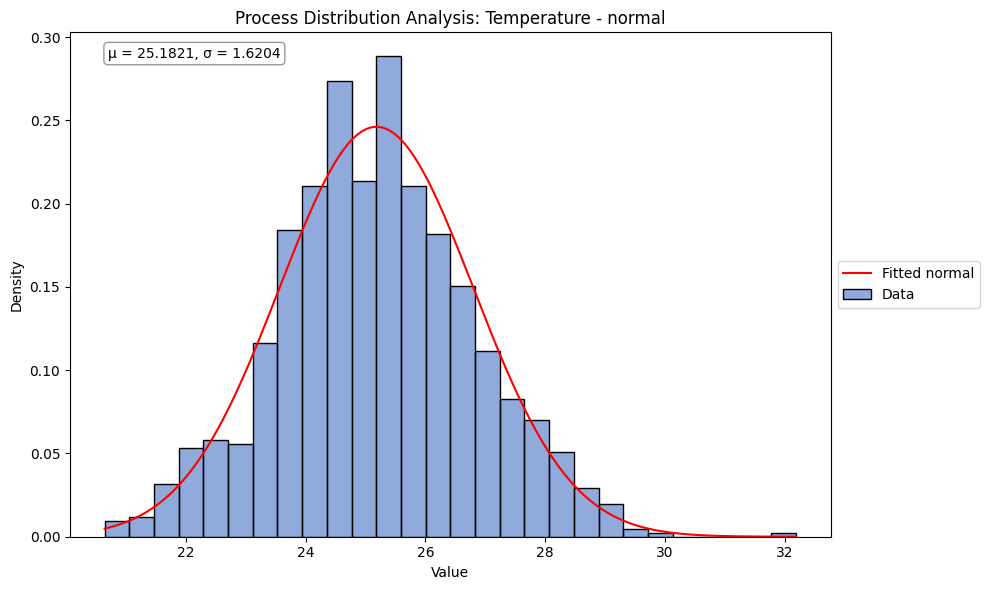

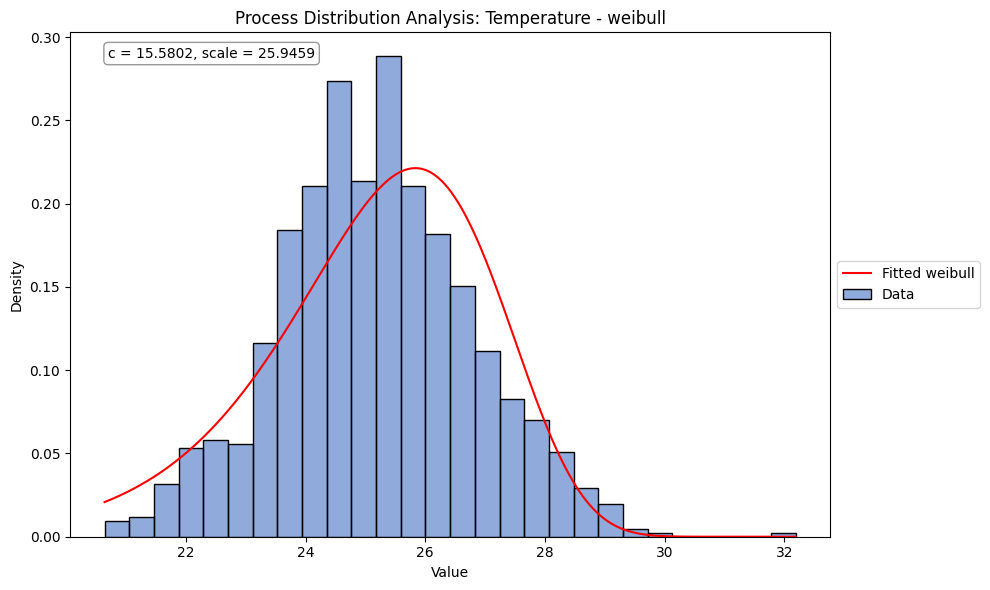

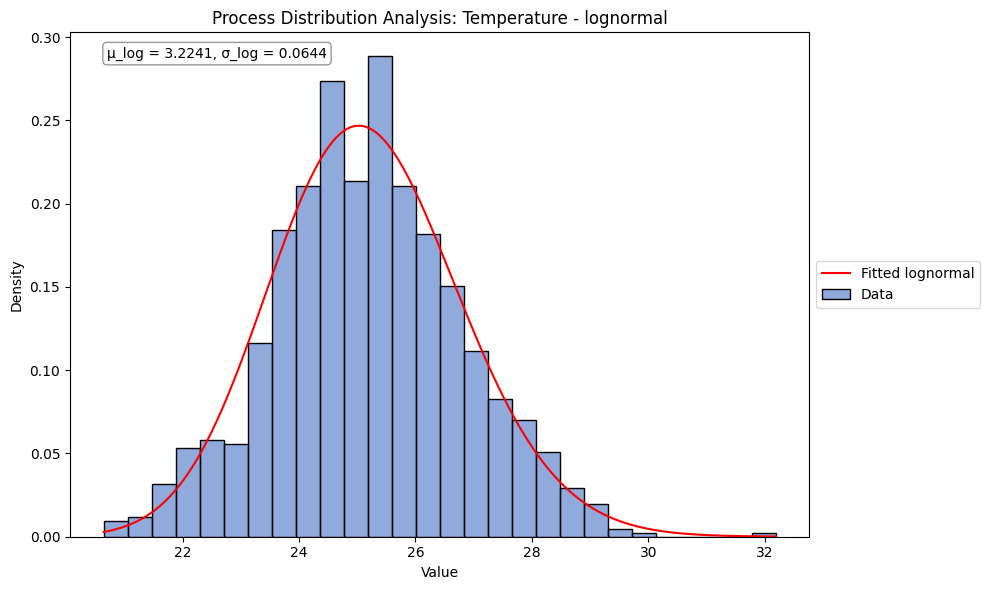

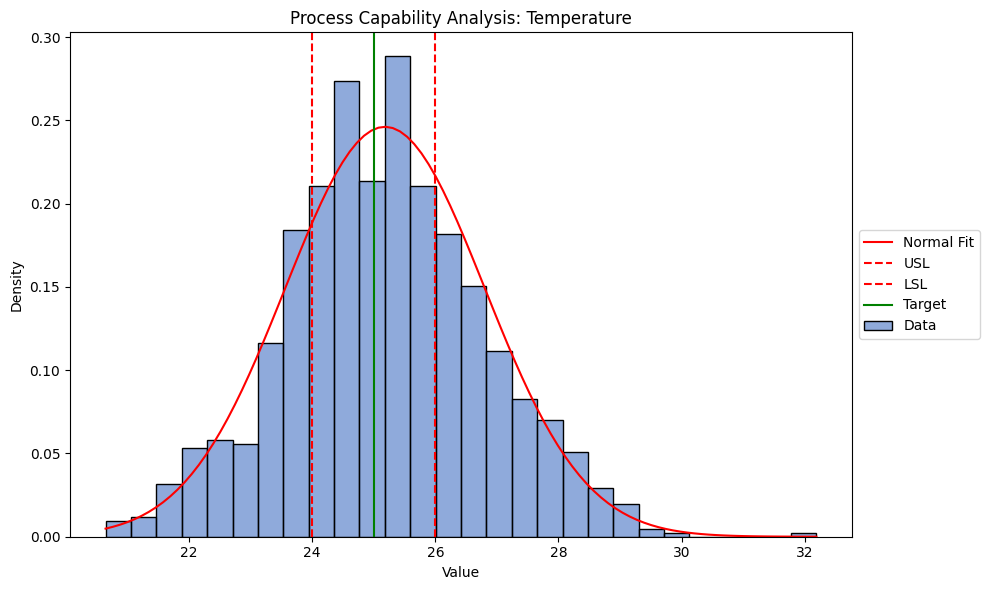


Principal Component Analysis Results:
Explained Variance Ratio: [0.9928046  0.00492751]

Mann-Whitney U Test Results:
U-statistic: 22442.0
p-value: 0.511


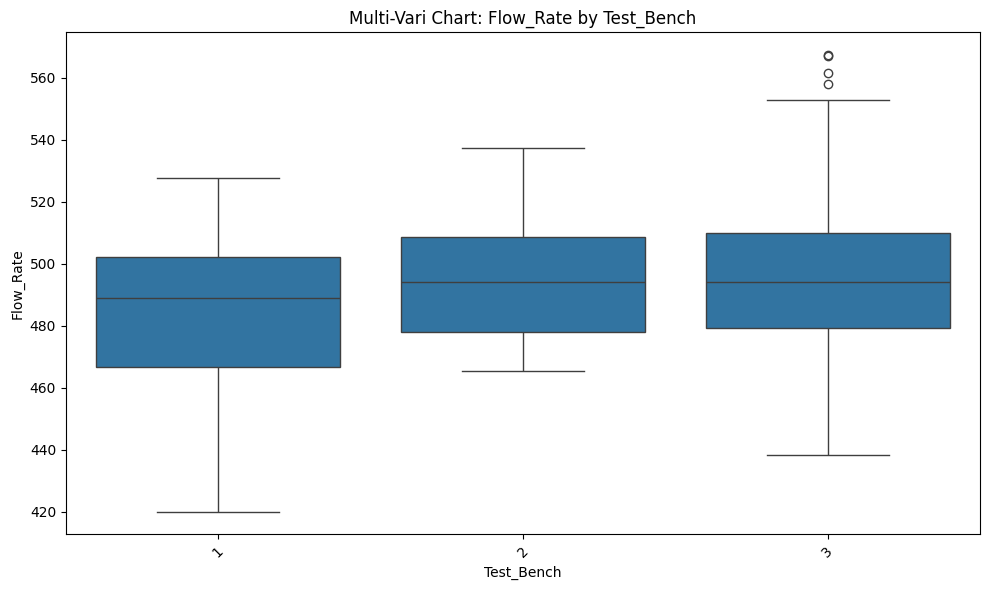

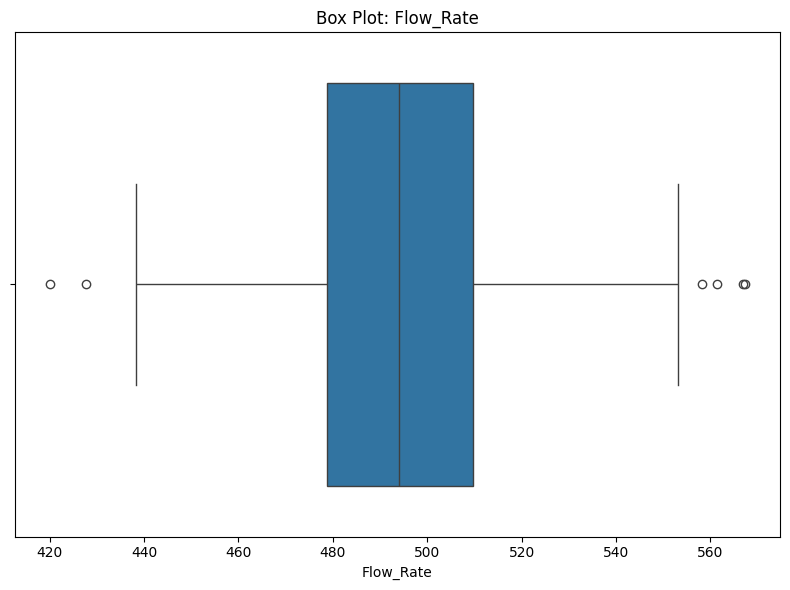

In [8]:
# Perform capability analysis on Temperature
pc.set_active_column('Temperature')


capability_results = pc.calculate_capability()
print("\nProcess Capability Analysis Results for Temperature:")
print(f"Samples: {capability_results['n']:.3f}")
print(f"Cp: {capability_results['Cp']:.3f}")
print(f"Cpk: {capability_results['Cpk']:.3f}")
print(f"Cpm: {capability_results['Cpm']:.3f}")
print(f"Cpkm: {capability_results['Cpkm']:.3f}")

# Fit and compare distributions
normal_fit = pc.fit_distribution('normal')
weibull_fit = pc.fit_distribution('weibull')
lognormal_fit = pc.fit_distribution('lognormal')

print("\nDistribution Fit Results for Temperature:")
print("\nNormal Distribution:")
#print(f"Parameters: {normal_fit['parameters']:}")
params = normal_fit['parameters']
print(f"Parameters: ({params[0]:.4f}, {params[1]:.4f})")
print(f"KS-statistic: {normal_fit['ks_stat']:.3f}")
print(f"KS-p-value: {normal_fit['ks_p']:.3f}")

print("\nWeibull Distribution:")
#print(f"Parameters: {weibull_fit['parameters']:}")
params = weibull_fit['parameters']
print(f"Parameters: ({params[0]:.4f}, {params[1]:.4f})")
print(f"KS-statistic: {weibull_fit['ks_stat']:.3f}")
print(f"KS-p-value: {weibull_fit['ks_p']:.3f}")

# Create visualizations for Temperature
pc.plot_distribution(normal_fit)
pc.plot_distribution(weibull_fit)
pc.plot_distribution(lognormal_fit)
pc.plot_capability()

# Perform multivariate analysis
mv_analysis = MultivariateAnalysis(pc.data)
principal_components, explained_variance = mv_analysis.principal_component_analysis(n_components=2)
print("\nPrincipal Component Analysis Results:")
#print(f"Principal Components:\n{principal_components}")
print(f"Explained Variance Ratio: {explained_variance}")

# Perform statistical tests
stats_tests = StatisticalTests(pc.data)
group1 = pc.data['Temperature'][:50]
group2 = pc.data['Temperature'][50:]
u_stat, p_value = stats_tests.mann_whitney_u_test(group1, group2)
print("\nMann-Whitney U Test Results:")
print(f"U-statistic: {u_stat}")
print(f"p-value: {p_value:.3f}")

# Create additional visualizations
viz = Visualization(pc.data)
viz.multi_vari_chart('Test_Bench', 'Flow_Rate')
viz.box_plot('Flow_Rate')
#viz.pareto_chart('Group', 'Value')


Process Capability Analysis Results for Pressure:
Cp: 0.073
Cpk: -5.383
Cpm: 0.004
Cpkm: -0.328

Distribution Fit Results for Pressure:

Normal Distribution:
Parameters: (100.1368, 4.5909)
KS-statistic: 0.019
KS-p-value: 0.853


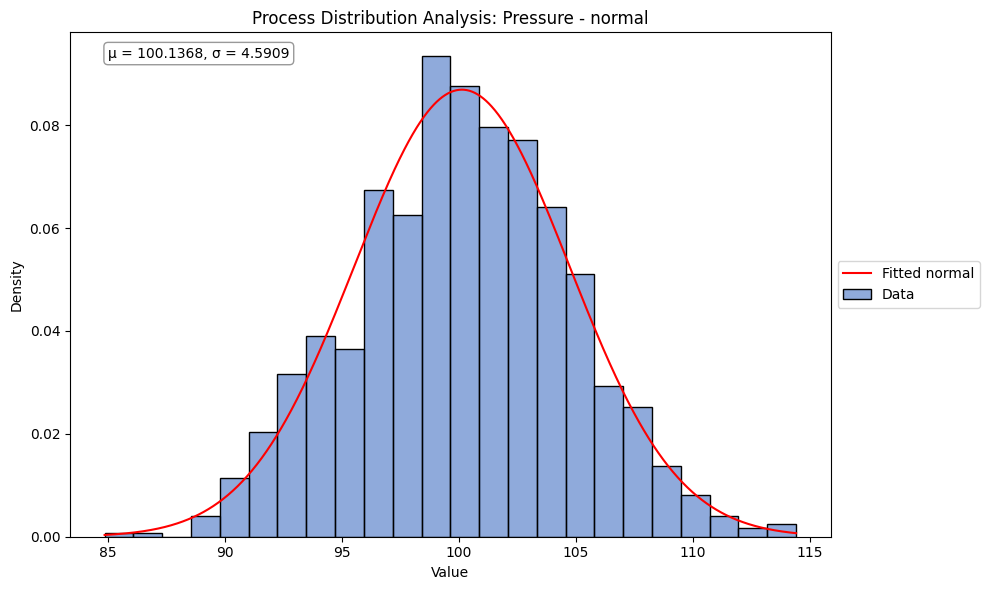

In [9]:
# Perform capability analysis on Pressure
pc.set_active_column('Pressure')


capability_results = pc.calculate_capability()
print("\nProcess Capability Analysis Results for Pressure:")
print(f"Cp: {capability_results['Cp']:.3f}")
print(f"Cpk: {capability_results['Cpk']:.3f}")
print(f"Cpm: {capability_results['Cpm']:.3f}")
print(f"Cpkm: {capability_results['Cpkm']:.3f}")

# Fit and compare distributions
normal_fit = pc.fit_distribution('normal')

print("\nDistribution Fit Results for Pressure:")
print("\nNormal Distribution:")
#print(f"Parameters: {normal_fit['parameters']:}")
params = normal_fit['parameters']
print(f"Parameters: ({params[0]:.4f}, {params[1]:.4f})")
print(f"KS-statistic: {normal_fit['ks_stat']:.3f}")
print(f"KS-p-value: {normal_fit['ks_p']:.3f}")

pc.plot_distribution(normal_fit)


Process Capability Analysis Results for Corrected_Flowrate:
Cp: 0.651
Cpk: 0.606
Cpm: 0.645
Cpkm: 0.601


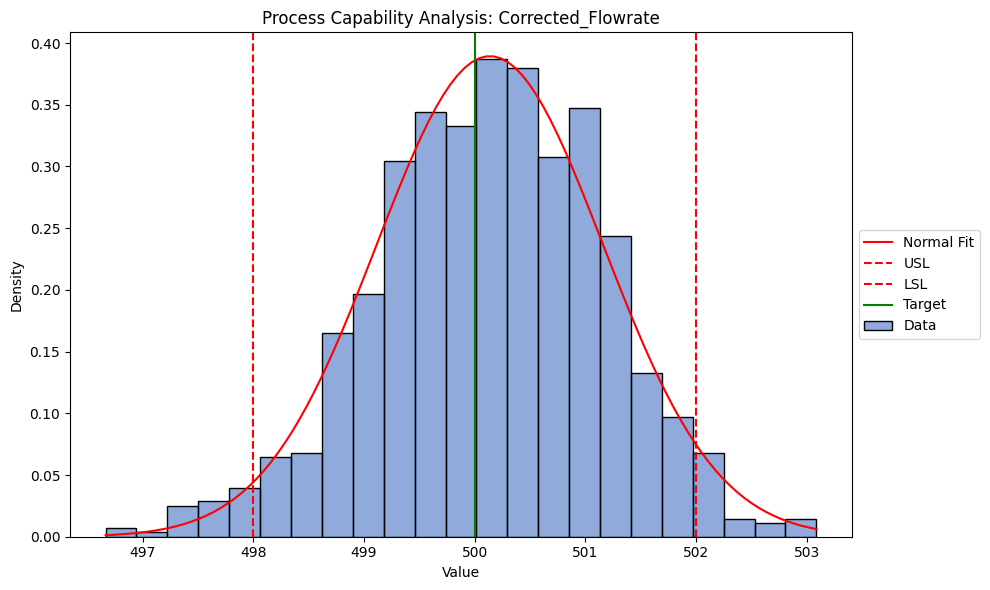


Process Capability Analysis Results for Diam:
Cp: 1.573
Cpk: 1.446
Cpm: 1.470
Cpkm: 1.351


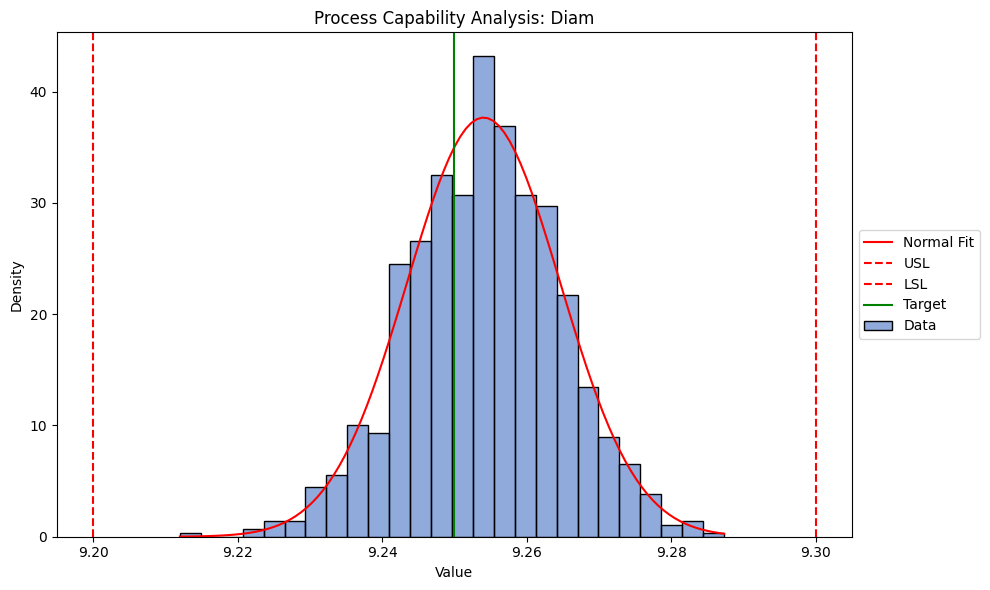


Process Capability Analysis Results for Diam:
Cp: 0.629
Cpk: 0.502
Cpm: 0.588
Cpkm: 0.469


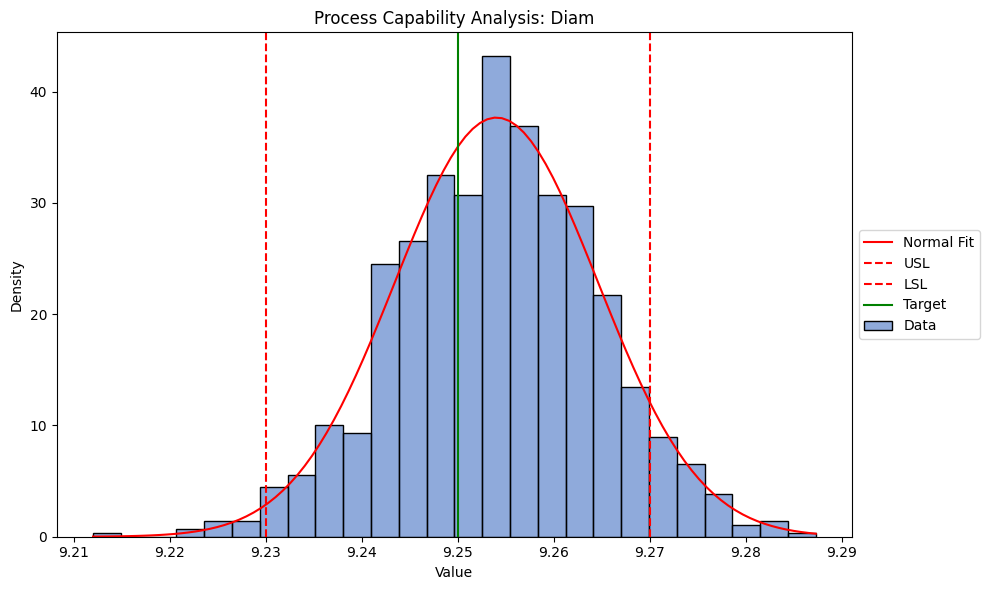

In [10]:
# Switch to another column for analysis
pc.set_active_column('Corrected_Flowrate')

# Set specification limits for Pressure
pc.set_specification_limits(usl=502.0, lsl=498.0, target=500.0)

# Perform capability analysis on Flow Rate
flow_capability = pc.calculate_capability()
print("\nProcess Capability Analysis Results for Corrected_Flowrate:")
print(f"Cp: {flow_capability['Cp']:.3f}")
print(f"Cpk: {flow_capability['Cpk']:.3f}")
print(f"Cpm: {flow_capability['Cpm']:.3f}")
print(f"Cpkm: {flow_capability['Cpkm']:.3f}")

# Plot capability for Flow Rate
pc.plot_capability()


# Switch to another column for analysis
pc.set_active_column('Diam')

# Set specification limits for Diam
pc.set_specification_limits(usl=9.3, lsl=9.2, target=9.25)

# Perform capability analysis on Diam
flow_capability = pc.calculate_capability()
print("\nProcess Capability Analysis Results for Diam:")
print(f"Cp: {flow_capability['Cp']:.3f}")
print(f"Cpk: {flow_capability['Cpk']:.3f}")
print(f"Cpm: {flow_capability['Cpm']:.3f}")
print(f"Cpkm: {flow_capability['Cpkm']:.3f}")

# Plot capability for Diam
pc.plot_capability()


# Switch to another column for analysis
pc.set_active_column('Diam')

# Set specification limits for Diam
pc.set_specification_limits(usl=9.27, lsl=9.23, target=9.25)

# Perform capability analysis on Diam
flow_capability = pc.calculate_capability()
print("\nProcess Capability Analysis Results for Diam:")
print(f"Cp: {flow_capability['Cp']:.3f}")
print(f"Cpk: {flow_capability['Cpk']:.3f}")
print(f"Cpm: {flow_capability['Cpm']:.3f}")
print(f"Cpkm: {flow_capability['Cpkm']:.3f}")

# Plot capability for Diam
pc.plot_capability()

## Correlation Matrix


Correlation between Temperature and Pressure:
Correlation coefficient: -0.0873
p-value: 5.7317e-03

Analyzing correlations between: ['Temperature', 'Pressure', 'Flow_Rate', 'Corrected_Flowrate', 'Diam']


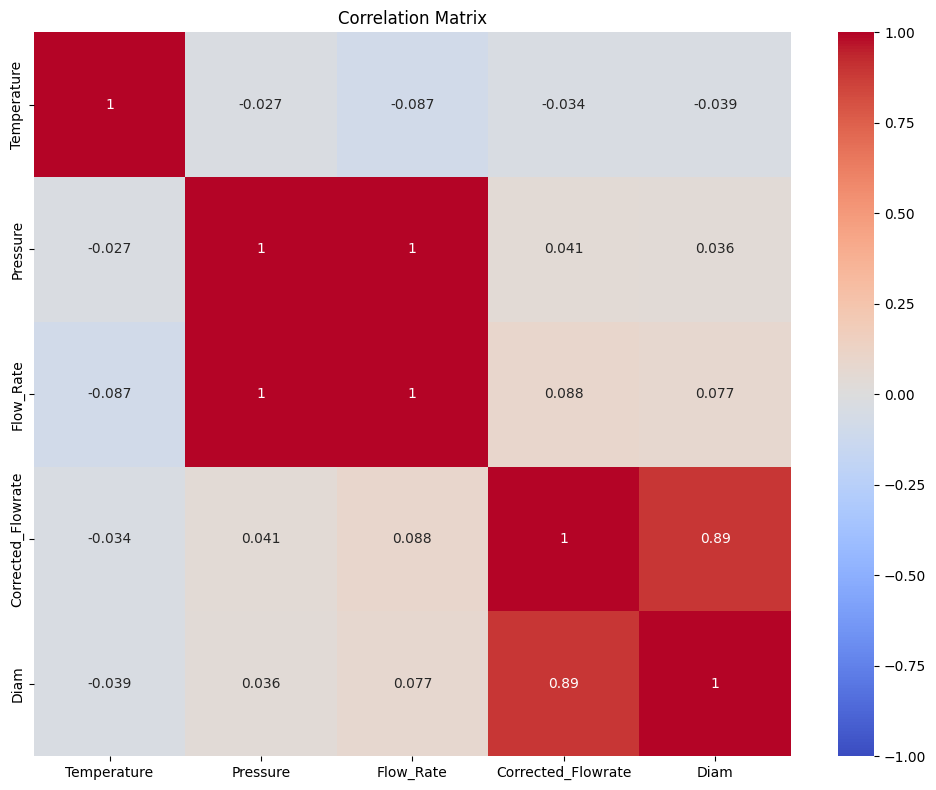

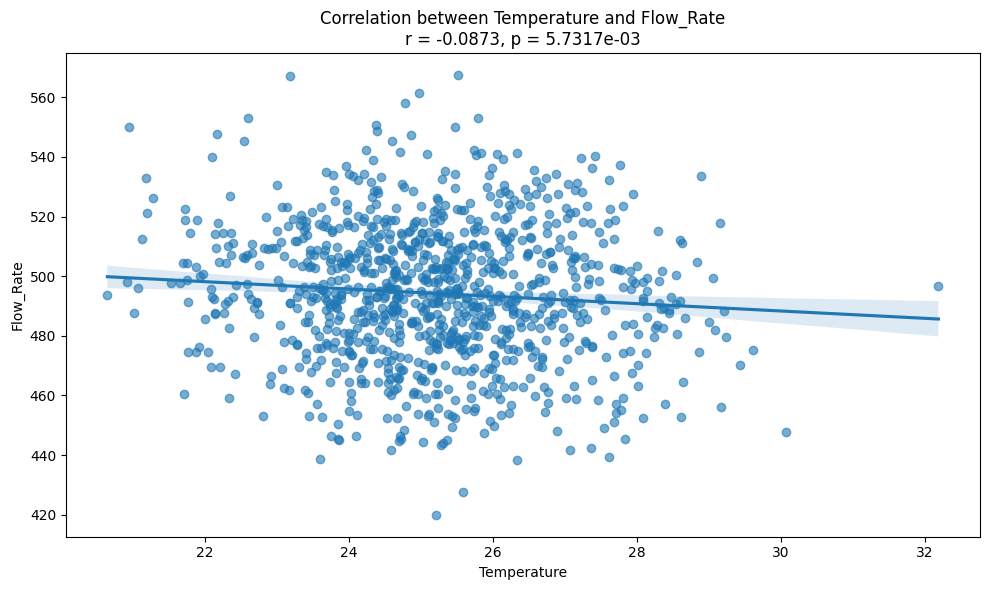

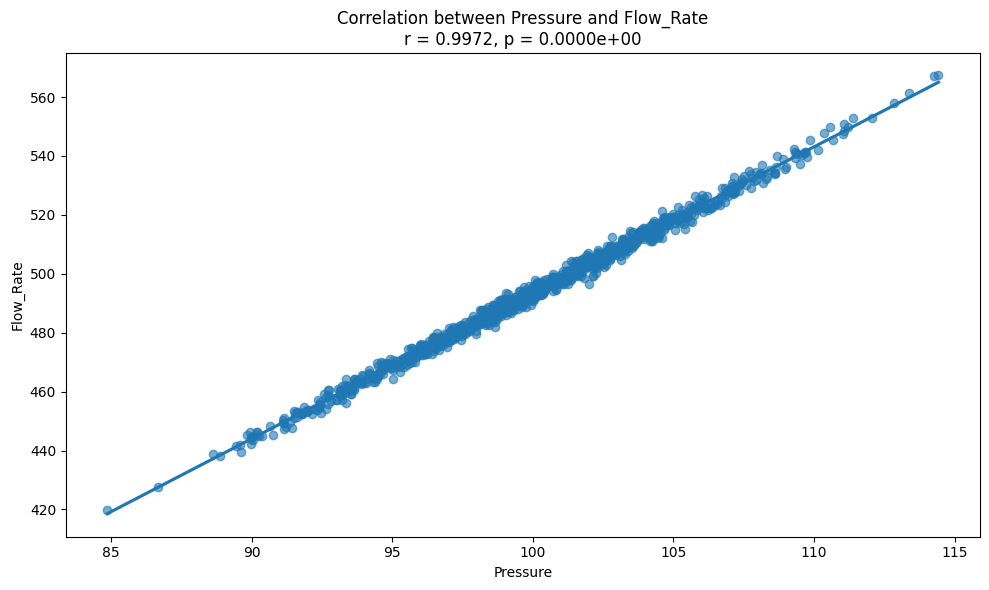

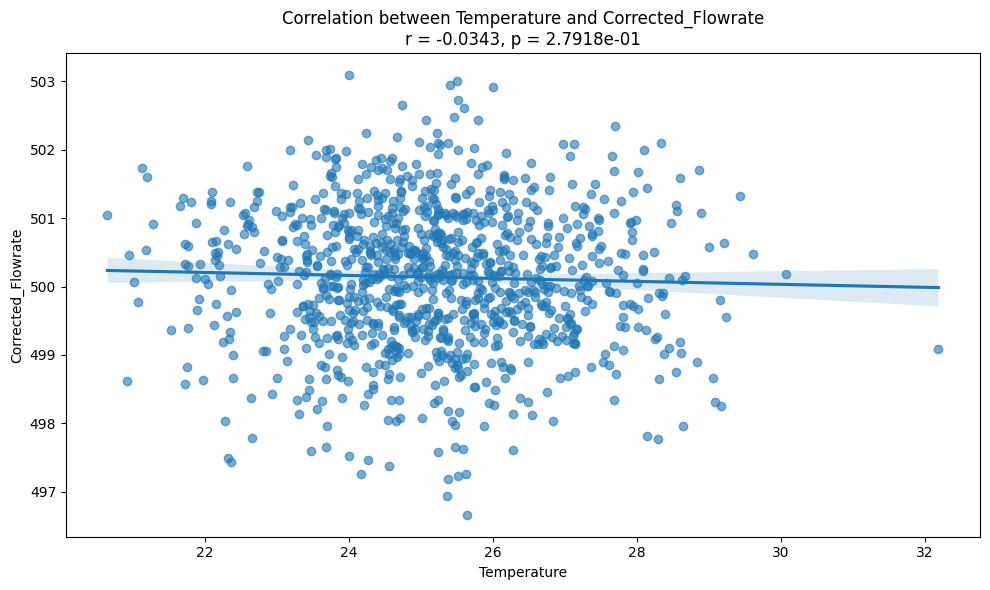

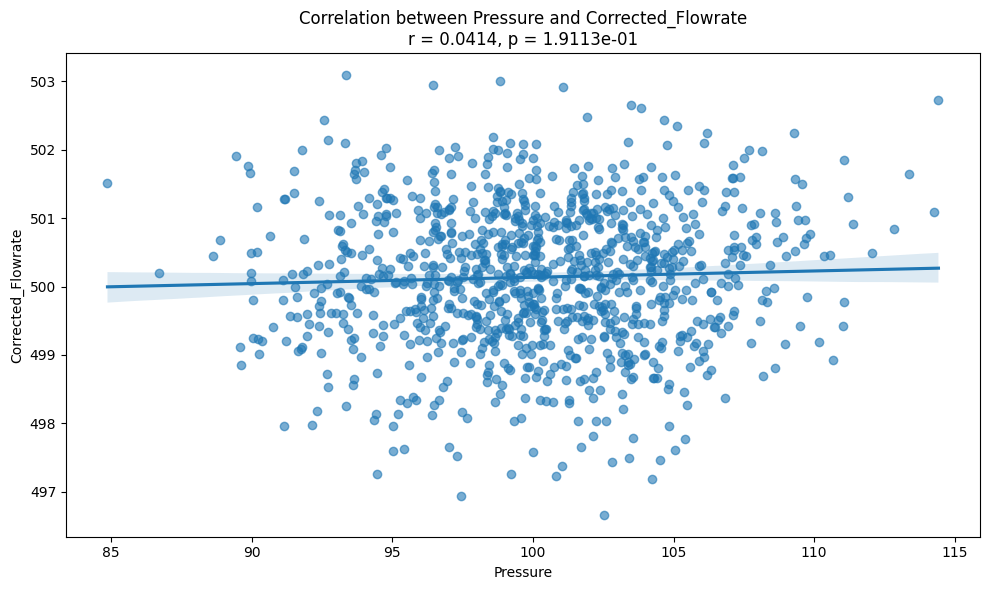

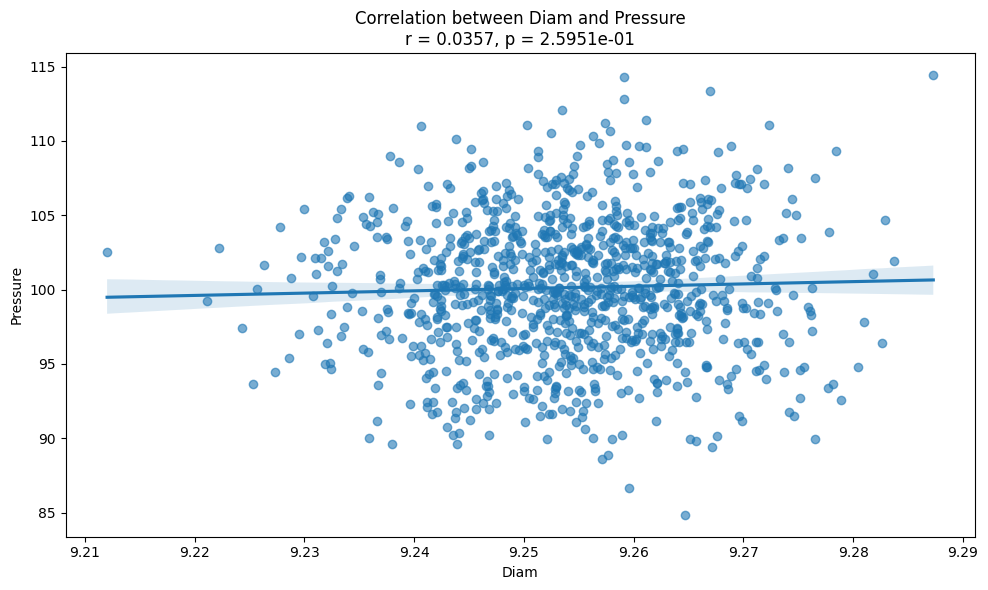

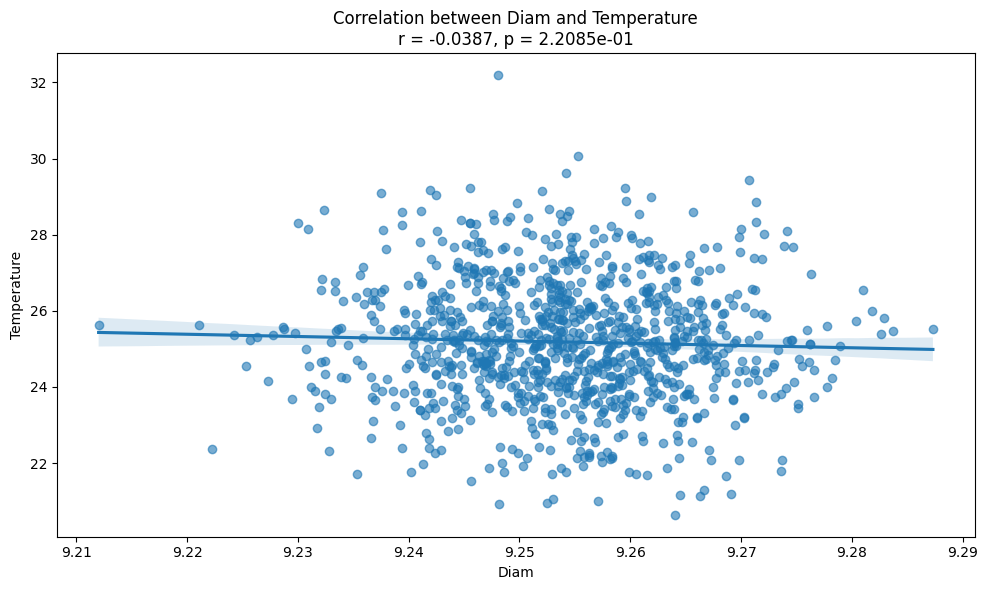

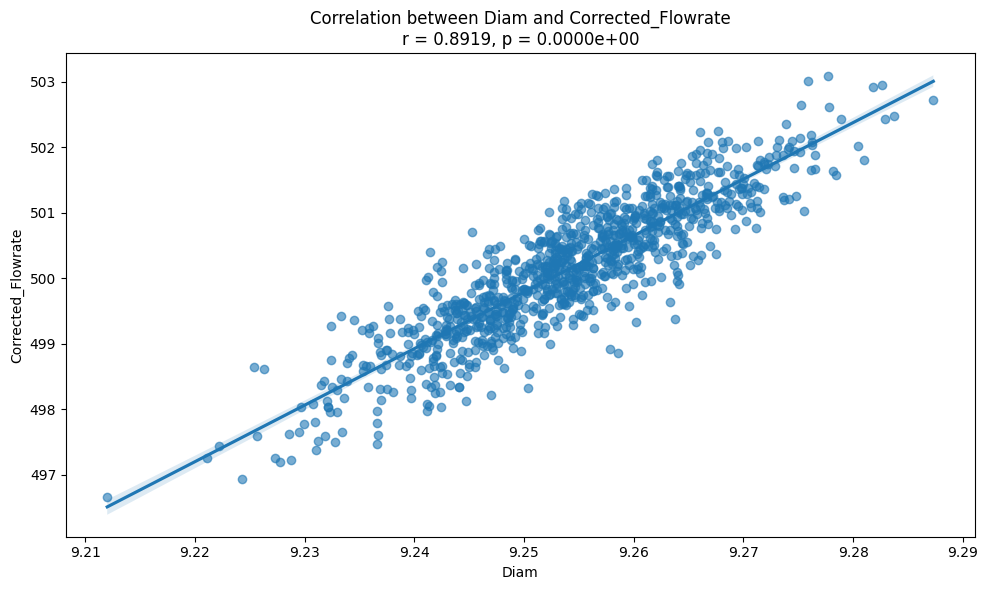

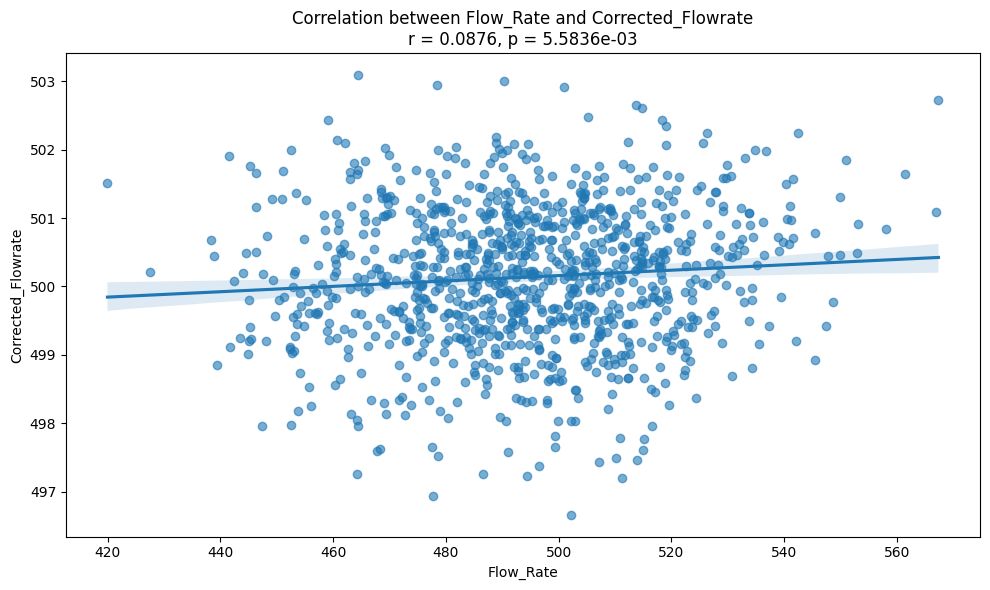

Ordered values at reference points:
σ = -1: 23.6661 (theoretical quantile = -1.0001)
σ = 0: 25.1719 (theoretical quantile = -0.0013)
σ = 1: 26.7899 (theoretical quantile = 1.0001)


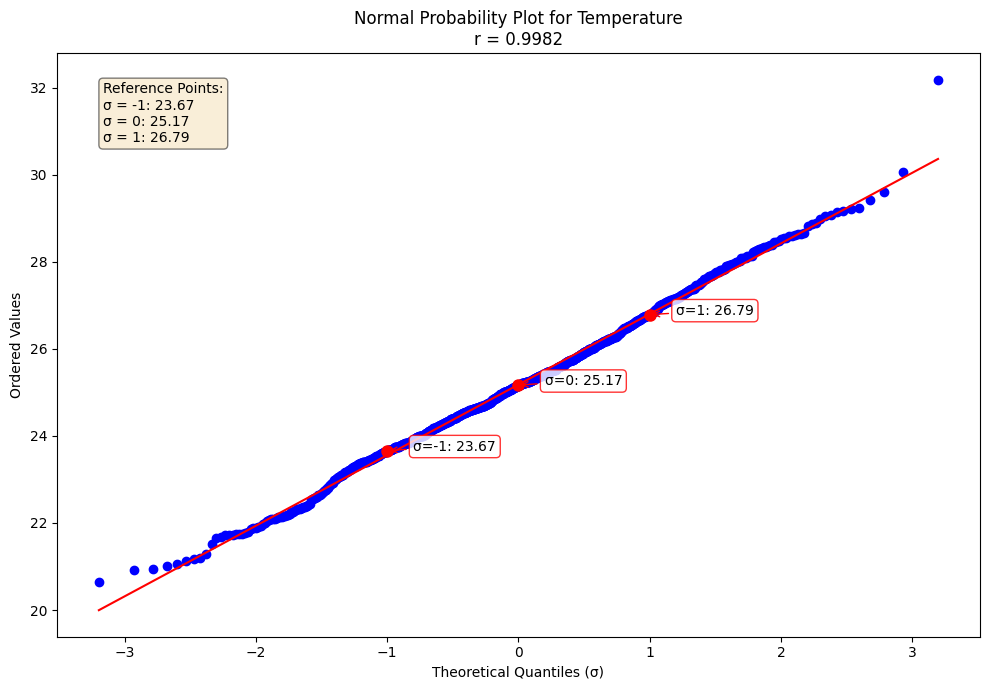

Ordered values at reference points:
σ = -1: 95.4245 (theoretical quantile = -1.0001)
σ = 0: 100.0765 (theoretical quantile = -0.0013)
σ = 1: 104.6625 (theoretical quantile = 1.0001)


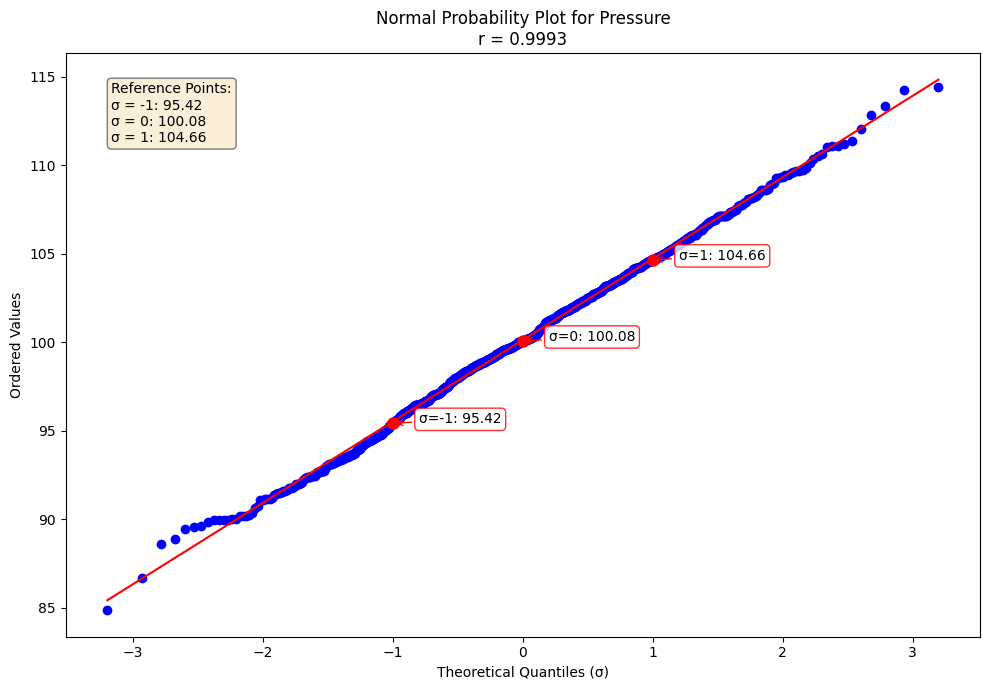

Ordered values at reference points:
σ = -1: 470.7364 (theoretical quantile = -1.0001)
σ = 0: 493.9493 (theoretical quantile = -0.0013)
σ = 1: 517.0661 (theoretical quantile = 1.0001)


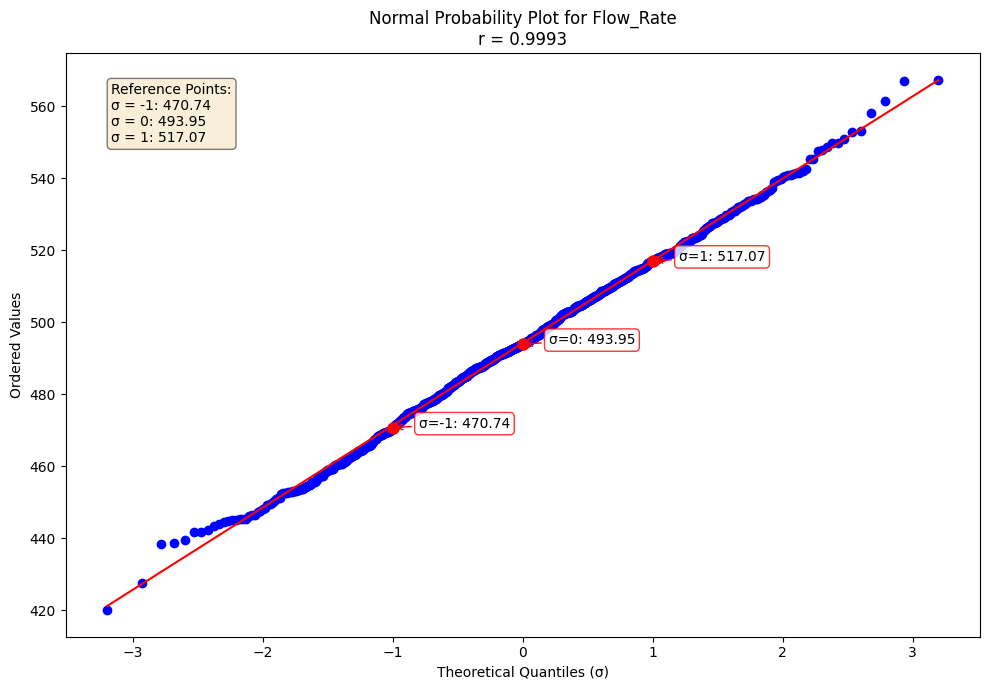

Ordered values at reference points:
σ = -1: 499.1496 (theoretical quantile = -1.0001)
σ = 0: 500.1746 (theoretical quantile = -0.0013)
σ = 1: 501.1527 (theoretical quantile = 1.0001)


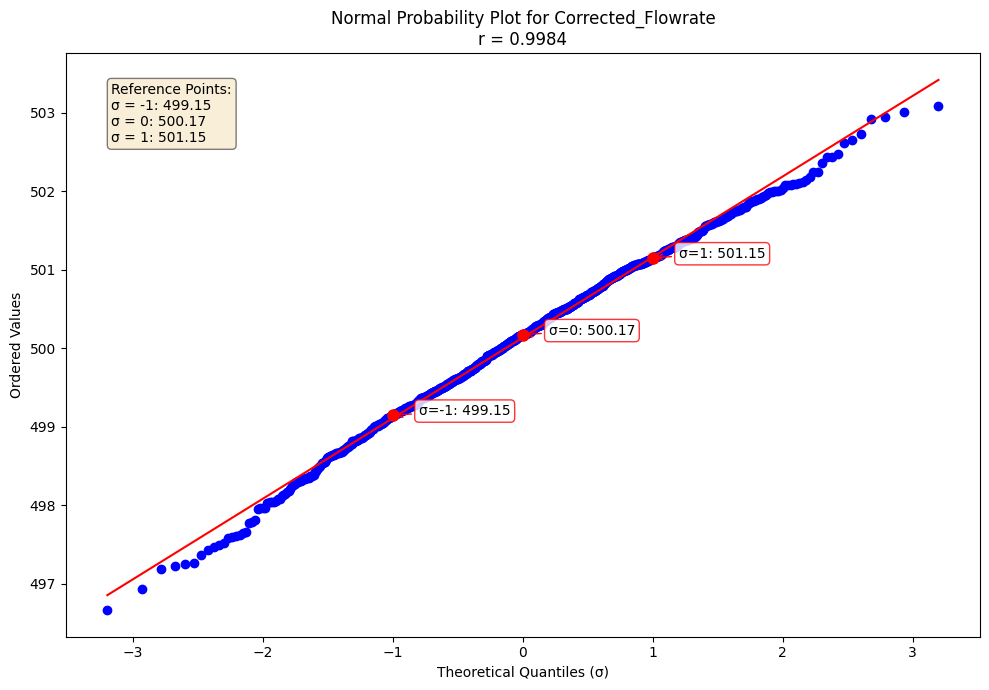

Ordered values at reference points:
σ = -1: 9.2437 (theoretical quantile = -1.0001)
σ = 0: 9.2541 (theoretical quantile = -0.0013)
σ = 1: 9.2644 (theoretical quantile = 1.0001)


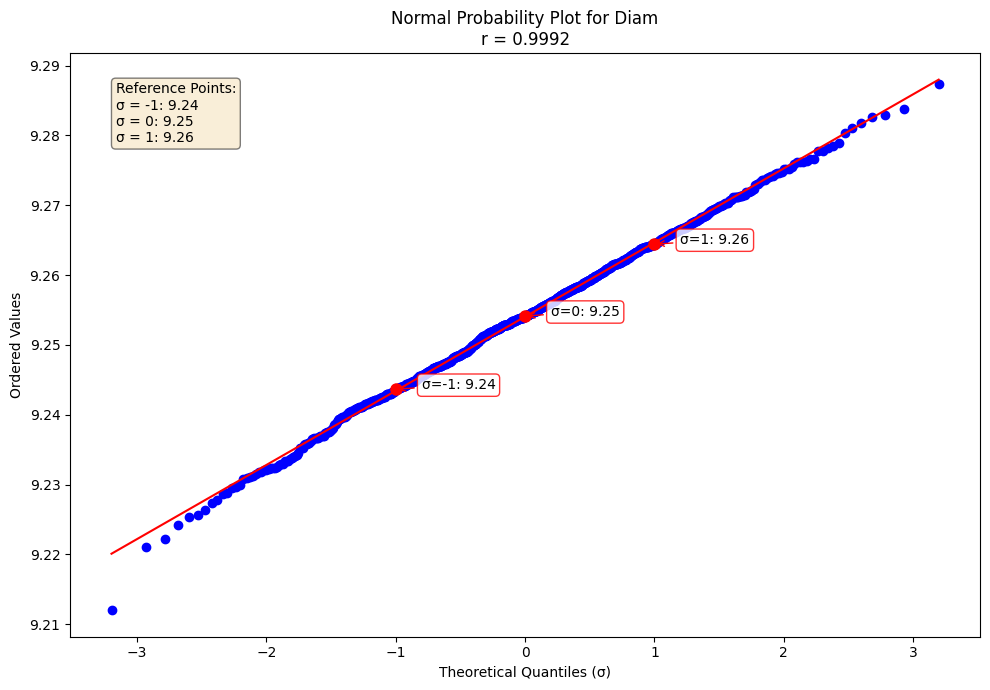

Ordered values at reference percentiles:
25th percentile: 9.2469 (theoretical quantile = 0.2495)
50th percentile: 9.2542 (theoretical quantile = 0.5005)
75th percentile: 9.2614 (theoretical quantile = 0.7495)


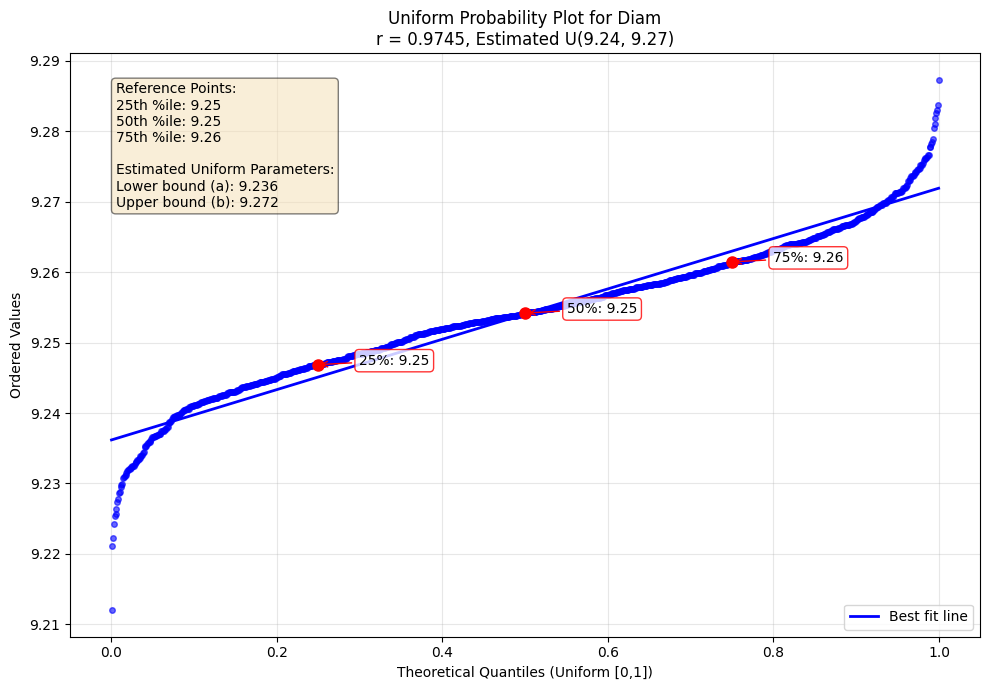

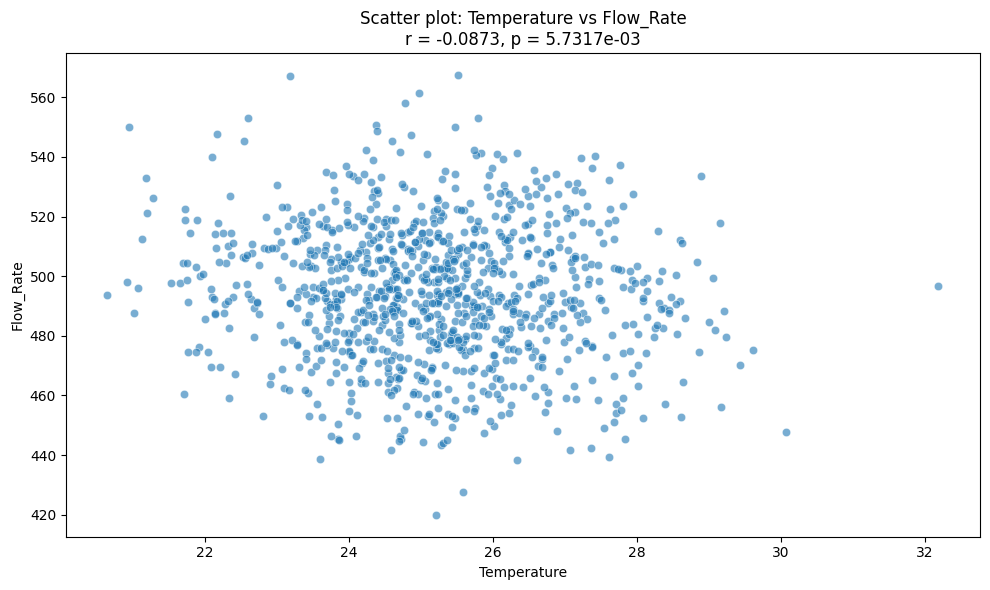

In [11]:
# Correlation analysis between Temperature and Pressure
corr, p_value = pc.calculate_correlation('Temperature', 'Flow_Rate')
print(f"\nCorrelation between Temperature and Pressure:")
print(f"Correlation coefficient: {corr:.4f}")
print(f"p-value: {p_value:.4e}")

# Analyze correlation between multiple columns
columns_of_interest = ['Temperature', 'Pressure', 'Flow_Rate','Corrected_Flowrate','Diam']

# Check if all columns exist in the dataset
available_columns = [col for col in columns_of_interest if col in pc.data.columns]
print(f"\nAnalyzing correlations between: {available_columns}")

# Generate and plot correlation matrix for available columns
pc.plot_correlation_matrix(available_columns)



# Visualize the correlation
pc.plot_correlation('Temperature', 'Flow_Rate')
pc.plot_correlation('Pressure', 'Flow_Rate')
pc.plot_correlation('Temperature', 'Corrected_Flowrate')
pc.plot_correlation('Pressure', 'Corrected_Flowrate')
pc.plot_correlation('Diam', 'Pressure')
pc.plot_correlation('Diam', 'Temperature')
pc.plot_correlation('Diam', 'Corrected_Flowrate')
pc.plot_correlation('Flow_Rate', 'Corrected_Flowrate')
pc.plot_normal_probability('Temperature')
pc.plot_normal_probability('Pressure')
pc.plot_normal_probability('Flow_Rate')
pc.plot_normal_probability('Corrected_Flowrate')
pc.plot_normal_probability('Diam')
pc.plot_uniform_probability('Diam')



# Example of analyzing a specific pair of columns with different visualization
if 'Temperature' in pc.data.columns and 'Flow_Rate' in pc.data.columns:
    pc.plot_correlation('Temperature', 'Flow_Rate', add_line=False)
    

## Bi-Variate Normal Analysis

In [12]:
def read_csv_data_mv(file_path, column=None):
    data = pd.read_csv(file_path)
    mv = MultivariateAnalysis(data)
    return mv


Bivariate Normal Statistics for Temperature and Pressure:
Mean: [25.1821, 100.1368]
Covariance Matrix:
[[ 2.62829963 -0.20105336]
 [-0.20105336 21.09762946]]
Correlation: -0.0270

Rolled Throughput Yield (RTY) Analysis:

Temperature:
  USL: 26
  Mean: 25.1821, Std Dev: 1.6212
  First Pass Yield: 69.30%

Pressure:
  USL: 115
  Mean: 100.1368, Std Dev: 4.5932
  First Pass Yield: 99.94%

Combined Analysis (Both Variables):
RTY (Assuming Independence): 69.26%
RTY (Monte Carlo Simulation): 69.27%
Combined Defect Rate: 30.73%

Difference due to correlation: 0.01 percentage points



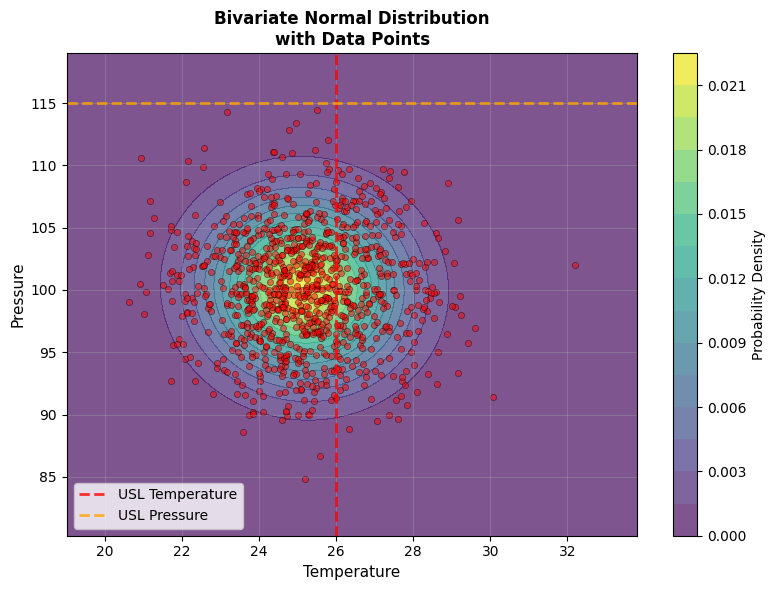

In [13]:
mv = read_csv_data_mv('./data/sample_manufacturing_data.csv')
fig_mpl, fig_plotly = mv.plot_bivariate_distribution('Temperature', 'Pressure', usl1=26, usl2=115, distribution='normal',n_points=300)
plt.show()
fig_plotly.show()

Estimated Weibull shape parameter: 893.8533
10th %ile: 9.2411 (theoretical quantile = 0.9975)
Median: 9.2542 (theoretical quantile = 0.9996)
90th %ile: 9.2675 (theoretical quantile = 1.0009)


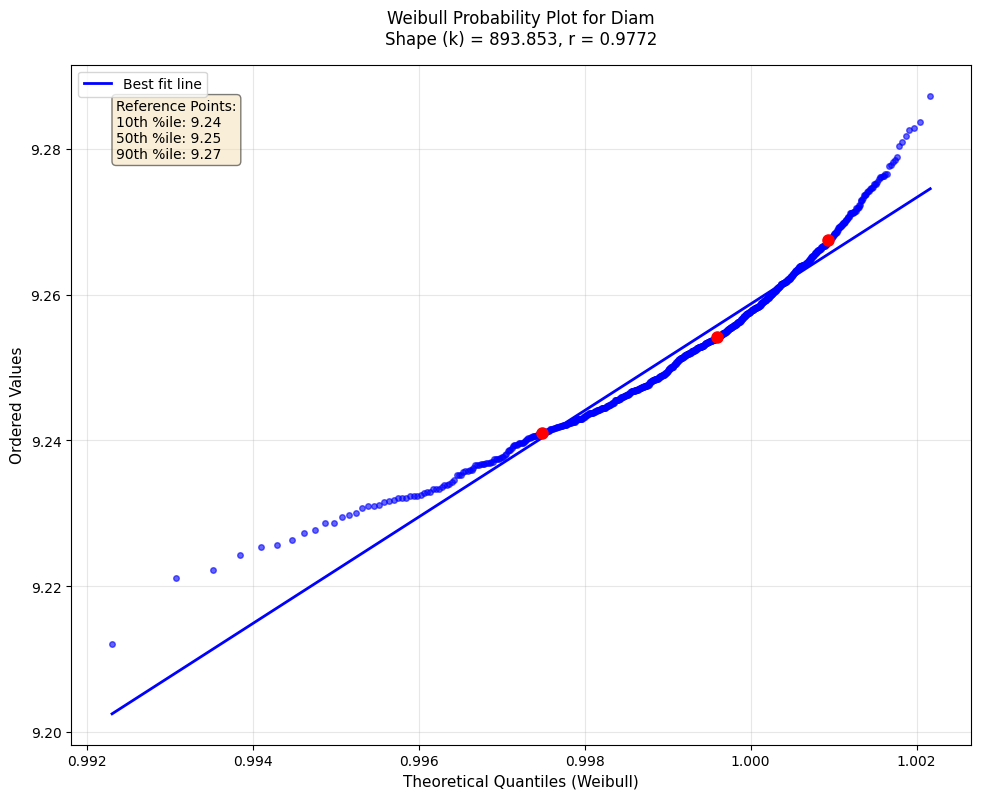

{'shape': np.float64(893.8532620412464),
 'scale': np.float64(7.303669385098038),
 'correlation': np.float64(0.9771958660907188)}

In [14]:
pc.plot_weibull_probability('Diam',shape=None)

Estimated Normal parameters for Diam: μ=9.2540, σ=0.0106
Estimated Normal parameters for Flow_Rate: μ=494.2520, σ=22.8165


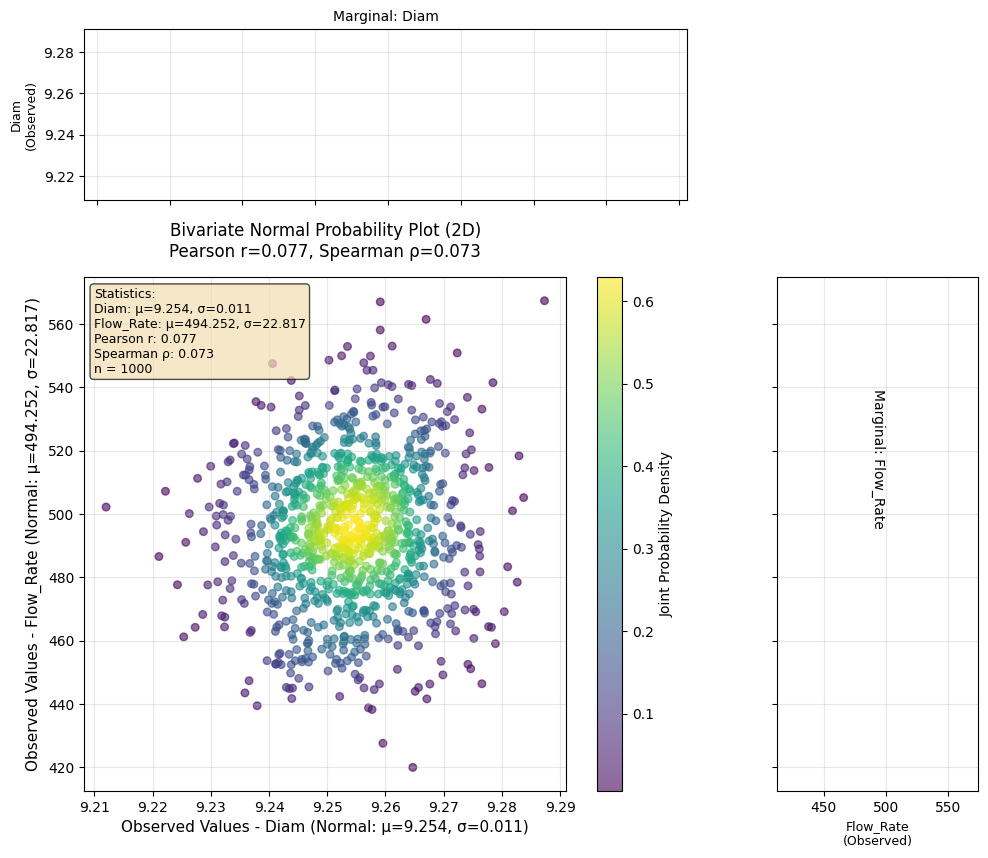

In [15]:
results = mv.plot_bivariate_probability('Diam', 'Flow_Rate', distribution='normal')